In [1]:
gene_familly = None

In [2]:
# Parameters
gene_familly = "LBD"


<div style="hwidth: 100%; background-color: #ddd; overflow:hidden; ">
    <div style="display: flex; justify-content: center; align-items: center; border-bottom: 10px solid #80c4e7; padding: 3px;">
        <h2 style="position: relative; top: 3px; left: 8px;">S2 Project: DNA Classification - (part2: Approach 2)</h2>
        <!--<img style="position: absolute; height: 68px; top: -2px;; right: 18px" src="./Content/Notebook-images/dna1.png"/>-->
    </div>
    <div style="padding: 3px 8px;">
        
1. <strong>Description</strong>:
   - In this approach, we represent DNA sequences using k-mer frequencies. Each sequence is encoded as a vector where each element represents the frequency of a specific k-mer in the sequence. This vector representation is then used as input to a neural network architecture for classification.

2. <strong>Pros</strong>:
   - Utilizes frequency analysis: By representing sequences based on the frequency of k-mers, the model can capture important patterns and motifs in the DNA sequences.
   - Flexible architecture: Neural networks provide a flexible framework for learning complex relationships between features, allowing the model to adapt to different types of data.

3. <strong>Cons</strong>:
   - Curse of dimensionality: Depending on the value of k and the size of the alphabet (e.g., DNA bases A, C, G, T), the feature space can become very large, leading to increased computational complexity and potential overfitting.
   - Loss of sequence information: By focusing solely on k-mer frequencies, the model may overlook important sequential dependencies and structural information present in the DNA sequences.
    </div>    
</div>

### 1 - Importing utils
The following code cells will import necessary libraries.

In [3]:
import os, random, string, itertools, warnings, sys, json
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from IPython.display import display, HTML
from sklearn.metrics import (
    confusion_matrix, 
    classification_report, 
    accuracy_score, 
    f1_score, 
    recall_score, 
    precision_score
)

from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import pad_sequences
from sklearn.feature_extraction import DictVectorizer
from keras.models import Sequential
from keras.layers import Dense, Input
from keras.layers import LSTM, SimpleRNN
from keras.layers import Flatten, Embedding, BatchNormalization, Dropout, MaxPooling1D, GlobalAveragePooling1D
from keras.preprocessing import sequence
from keras.layers import Conv1D

# OS
current_directory = os.getcwd()
root_directory = os.path.abspath(os.path.join(current_directory, os.pardir))
utils_directory = os.path.join(root_directory, 'processing')
sys.path.append(utils_directory)

# Import Utils
import fasta
from representation import DNA
from visualization import VISU, VISUReport

In [4]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  0


### 2 - Importing Dataset
The following function will read our preprocessed **.csv file** and return a pandas dataframe

In [5]:
# READ GENE_INFO JSON FILE

gene_info_path = "../data/gene_info.json"
dataset_path   = "../data/one_vs_other/"
with open(gene_info_path, 'r') as json_file:
    gene_info = json.load(json_file)

In [6]:
# FOCUS ON GENE FAMALLY

gene_dict = gene_info[gene_familly]
df_path = dataset_path+gene_dict['file_code']+".csv"

In [7]:
USE_FULL_DF = False

if USE_FULL_DF:
    dataset = pd.read_csv(df_path)
else:
    dataset_ = pd.read_csv(df_path)
    r = min(5000/len(dataset_), 1)
    _, dataset = train_test_split(dataset_, test_size=r, stratify=dataset_['class'], random_state=42)
dataset.head()

,id,sequence,length,class
6720,Vang0057ss00850.1,MLLSFYSQTKQEILQLPFFSRNQMAGNSPCASCKLLRRRCTKDCIF...,189,1
8140,DCAR_018466,MESKYHQEDSTNSSSGEESDQVELHNSGLSRSYECVFCKRGFTTAQ...,148,0
2226,Glyma.01G143900.1.p,MSINSSCSISGGSSSGGNNNSSGGSPCGACKFLRRKCMPGCIFAPY...,248,1
8800,Pta002777,MNVLDQIRQHLLGESDGSPSFCTGSPAESCLTENYASSNSWNASEE...,315,0
4052,XP_009630484.1,MRLSCNGCRVLRKGCNEKCSIKPCLQWIKSPEAQSNATLFLAKFYG...,248,1


In [8]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5000 entries, 6720 to 13648
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        5000 non-null   object
 1   sequence  5000 non-null   object
 2   length    5000 non-null   int64 
 3   class     5000 non-null   int64 
dtypes: int64(2), object(2)
memory usage: 195.3+ KB


In [9]:
report = VISUReport(gene_familly, dataset)

* **Model Utils**

In [10]:
domaine = "ACDEFGHIKLMNPQRSTVWYX"
def model_checkpoint(model_name):
    gene_familly_ = gene_familly.replace('/', '__')
    return tf.keras.callbacks.ModelCheckpoint(
        filepath="Output/Model/"+gene_familly_+"/"+model_name+".keras", 
        monitor='val_loss', 
        verbose=0, 
        save_best_only=True, 
        save_weights_only=False
    )
def early_stopping(patience=10):
    return tf.keras.callbacks.EarlyStopping(
        monitor="val_accuracy",
        patience=patience,
        verbose=0,
    )

### 4 - Training and Testing

<h4 style="background-color: #80c4e6; display: flex;">
    <ul><li>k=2</li></ul>
</h4>

In [11]:
k = 2
X, y, features_k2 = DNA.build_kmer_representation_v2(dataset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y) #, random_state=42
X_test.head()

,AA,AC,AD,AE,AF,AG,AH,AI,AK,AL,...,YN,YP,YQ,YR,YS,YT,YV,YW,YX,YY
4761,0.075330,0.000000,0.009416,0.007533,0.000000,0.020716,0.001883,0.001883,0.001883,0.003766,...,0.000000,0.0,0.000000,0.000000,0.000000,0.001883,0.001883,0.0,0.0,0.000000
360,0.000000,0.000000,0.000000,0.004367,0.004367,0.004367,0.000000,0.004367,0.004367,0.013100,...,0.000000,0.0,0.004367,0.000000,0.000000,0.004367,0.000000,0.0,0.0,0.000000
4801,0.011647,0.003328,0.003328,0.003328,0.001664,0.006656,0.004992,0.000000,0.008319,0.001664,...,0.000000,0.0,0.000000,0.008319,0.003328,0.000000,0.003328,0.0,0.0,0.000000
448,0.013423,0.013423,0.000000,0.013423,0.000000,0.000000,0.013423,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000
1766,0.016878,0.004219,0.000000,0.000000,0.004219,0.000000,0.012658,0.008439,0.000000,0.004219,...,0.008439,0.0,0.008439,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.004219


In [12]:
print("X_train:", X_train.shape)
print("X_test:", X_test.shape)
print("y_train:", y_train.shape)
print("y_test:", y_test.shape)

NUM_CLASS  = 1
SEQ_LENGTH = X_train.shape[1]

X_train: (4000, 441)
X_test: (1000, 441)
y_train: (4000,)
y_test: (1000,)


* <span style="color: blue; font-weight: bold;">MODEL 1 : FEED-FORWARD NETWORKS</span>

In [13]:
name="FEEDFORWARD_k2"
def feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):
    model = Sequential(name=name)
    model.add(Input(shape=(SEQ_LENGTH,)))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(num_output, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

# Build & train the model
model = feedforward_net1()
stop_callback = early_stopping(patience=10)
save_callback = model_checkpoint(name)

X_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)
history = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])

# Evaluate and score
test_scores = model.evaluate(X_test, y_test, verbose=0)
train_score = history.history.get('accuracy')[-1]
print("\n[Train Accuracy: {:.2f}% - Test Accuracy: {:.2f}%]".format(train_score*100, test_scores[1]*100))

Model: "FEEDFORWARD_k2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 256)                 │         113,152 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 156,417 (611.00 KB)

 Trainable params: 156,417 (611.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 21s 441ms/step - accuracy: 0.5938 - loss: 0.6928

35/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6726 - loss: 0.6757   

50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7171 - loss: 0.6460 - val_accuracy: 0.9388 - val_loss: 0.1894


Epoch 2/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9219 - loss: 0.1821

35/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9465 - loss: 0.1596

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9497 - loss: 0.1483 - val_accuracy: 0.9688 - val_loss: 0.0852


Epoch 3/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 0.0214

29/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9798 - loss: 0.0646

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9779 - loss: 0.0691 - val_accuracy: 0.9750 - val_loss: 0.0674


Epoch 4/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9844 - loss: 0.0289

30/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9811 - loss: 0.0537

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9811 - loss: 0.0555 - val_accuracy: 0.9787 - val_loss: 0.0641


Epoch 5/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 0.0084

31/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9887 - loss: 0.0361

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9874 - loss: 0.0413 - val_accuracy: 0.9812 - val_loss: 0.0621


Epoch 6/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9688 - loss: 0.0579

31/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9861 - loss: 0.0376

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9873 - loss: 0.0373 - val_accuracy: 0.9675 - val_loss: 0.0938


Epoch 7/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9688 - loss: 0.0614

31/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9880 - loss: 0.0325

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9889 - loss: 0.0335 - val_accuracy: 0.9762 - val_loss: 0.0765


Epoch 8/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9844 - loss: 0.0470

31/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9832 - loss: 0.0516

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9825 - loss: 0.0535 - val_accuracy: 0.9775 - val_loss: 0.0734


Epoch 9/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.0099

31/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9951 - loss: 0.0159

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9939 - loss: 0.0190 - val_accuracy: 0.9750 - val_loss: 0.0780


Epoch 10/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.0131

30/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9976 - loss: 0.0135

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9957 - loss: 0.0180 - val_accuracy: 0.9775 - val_loss: 0.0719


Epoch 11/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 0.0028

32/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9917 - loss: 0.0295

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9928 - loss: 0.0261 - val_accuracy: 0.9787 - val_loss: 0.0711


Epoch 12/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 0.0022

31/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9993 - loss: 0.0055

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9984 - loss: 0.0087 - val_accuracy: 0.9775 - val_loss: 0.0888


Epoch 13/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9688 - loss: 0.0729

31/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9835 - loss: 0.0403

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9854 - loss: 0.0356 - val_accuracy: 0.9750 - val_loss: 0.0837


Epoch 14/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 0.0140

30/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9920 - loss: 0.0328

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9927 - loss: 0.0286 - val_accuracy: 0.9775 - val_loss: 0.0766


Epoch 15/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9844 - loss: 0.0600

31/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9960 - loss: 0.0131

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9964 - loss: 0.0119 - val_accuracy: 0.9737 - val_loss: 0.1060



[Train Accuracy: 99.69% - Test Accuracy: 97.40%]


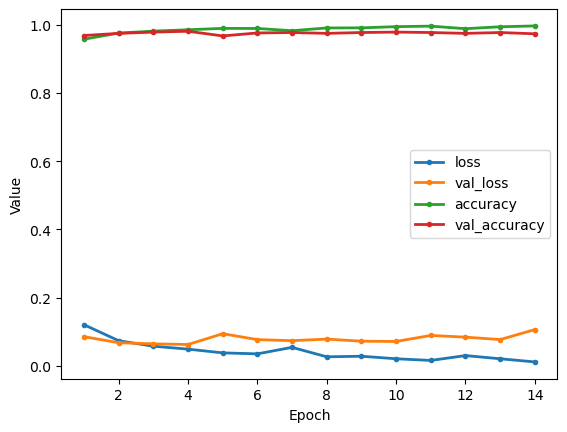

In [14]:
VISU.plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])

In [15]:
VISU.test_report(X_test, y_test, model=model,  args=[model.name, test_scores[1]*100, gene_familly, features_k2, len(dataset)]) 
report.add_report(X_test, y_test, model=model, history=history, args=[model.name, "---"])

 1/32 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 864us/step


 1/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 455us/step


<h4 style="background-color: #80c4e6; display: flex;">
    <ul><li>k=3</li></ul>
</h4>

In [16]:
k = 3
X, y, features_k3 = DNA.build_kmer_representation_v2(dataset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_test.head()

,AAA,AAC,AAD,AAE,AAF,AAG,AAH,AAI,AAK,AAL,...,YYN,YYP,YYQ,YYR,YYS,YYT,YYV,YYW,YYX,YYY
3354,0.004902,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3820,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.005435,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3288,0.000000,0.000000,0.0,0.0,0.0,0.001613,0.001613,0.000000,0.001613,0.001613,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4760,0.015873,0.003968,0.0,0.0,0.0,0.003968,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2965,0.003460,0.006920,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [17]:
print("X_train:", X_train.shape)
print("X_test:", X_test.shape)
print("y_train:", y_train.shape)
print("y_test:", y_test.shape)

NUM_CLASS  = 1
SEQ_LENGTH = X_train.shape[1]

X_train: (4000, 8703)
X_test: (1000, 8703)
y_train: (4000,)
y_test: (1000,)


* <span style="color: blue; font-weight: bold;">MODEL 1 : FEED-FORWARD NETWORKS</span>

In [18]:
name="FEEDFORWARD_k3"
def feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):
    model = Sequential(name=name)
    model.add(Input(shape=(SEQ_LENGTH,)))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(num_output, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

# Build & train the model
model = feedforward_net1()
stop_callback = early_stopping(patience=10)
save_callback = model_checkpoint(name)

X_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)
history = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])

# Evaluate and score
test_scores = model.evaluate(X_test, y_test, verbose=0)
train_score = history.history.get('accuracy')[-1]
print("\n[Train Accuracy: {:.2f}% - Test Accuracy: {:.2f}%]".format(train_score*100, test_scores[1]*100))

Model: "FEEDFORWARD_k3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_5 (Dense)                      │ (None, 256)                 │       2,228,224 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,271,489 (8.67 MB)

 Trainable params: 2,271,489 (8.67 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 22s 465ms/step - accuracy: 0.3906 - loss: 0.6932

 9/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4763 - loss: 0.6925   

17/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5401 - loss: 0.6907

25/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5918 - loss: 0.6869

33/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6322 - loss: 0.6796

41/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6647 - loss: 0.6674

49/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6912 - loss: 0.6499

50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.6970 - loss: 0.6449 - val_accuracy: 0.9663 - val_loss: 0.1201


Epoch 2/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9375 - loss: 0.1528

 9/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9701 - loss: 0.1057 

18/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9731 - loss: 0.0942

27/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9759 - loss: 0.0858

35/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9777 - loss: 0.0796

44/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9794 - loss: 0.0740

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9804 - loss: 0.0706 - val_accuracy: 0.9937 - val_loss: 0.0308


Epoch 3/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 1.0000 - loss: 0.0065

 9/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 0.0066 

18/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9990 - loss: 0.0074

27/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9986 - loss: 0.0078

36/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9985 - loss: 0.0080

44/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9984 - loss: 0.0080

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9984 - loss: 0.0079 - val_accuracy: 0.9937 - val_loss: 0.0280


Epoch 4/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 1.0000 - loss: 0.0024

 9/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 0.0059 

18/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 0.0049

27/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 0.0042

35/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 0.0039

44/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 0.0036

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.0035 - val_accuracy: 0.9912 - val_loss: 0.0422


Epoch 5/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 1.0000 - loss: 6.4230e-04

 9/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 6.5662e-04 

17/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 9.1395e-04

26/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 0.0011    

35/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 0.0012

44/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 0.0012

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.0012 - val_accuracy: 0.9937 - val_loss: 0.0312


Epoch 6/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 1.0000 - loss: 7.1283e-04

10/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 7.1152e-04 

19/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 6.5747e-04

28/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 6.1879e-04

37/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 6.0859e-04

46/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 6.0447e-04

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 6.0588e-04 - val_accuracy: 0.9937 - val_loss: 0.0302


Epoch 7/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 1.0000 - loss: 1.8465e-04

 9/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 4.1030e-04 

18/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 4.8150e-04

27/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 4.7389e-04

35/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 4.7157e-04

44/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 4.7018e-04

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 4.6742e-04 - val_accuracy: 0.9925 - val_loss: 0.0351


Epoch 8/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 1.0000 - loss: 2.3281e-04

 9/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 2.2758e-04 

17/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 3.0096e-04

25/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 3.1633e-04

34/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 3.2908e-04

43/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 3.5568e-04

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 3.7620e-04 - val_accuracy: 0.9925 - val_loss: 0.0401


Epoch 9/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 1.0000 - loss: 7.6338e-04

10/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 3.4096e-04 

19/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 2.9503e-04

27/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 2.7535e-04

35/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 2.6000e-04

43/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 2.4980e-04

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.4096e-04 - val_accuracy: 0.9925 - val_loss: 0.0441


Epoch 10/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 1.0000 - loss: 7.4178e-05

 9/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 2.7397e-04 

18/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 2.5318e-04

26/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 2.3716e-04

34/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 2.2933e-04

43/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 2.2493e-04

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.2241e-04 - val_accuracy: 0.9925 - val_loss: 0.0410


Epoch 11/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 1.0000 - loss: 6.9130e-05

10/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.1200e-04 

19/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.3001e-04

27/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.3425e-04

36/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.3463e-04

44/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.3529e-04

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.3545e-04 - val_accuracy: 0.9925 - val_loss: 0.0444


Epoch 12/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 1.0000 - loss: 1.1190e-04

 9/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.1866e-04 

17/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.1343e-04

25/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.1589e-04

33/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.1417e-04

41/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.1168e-04

49/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.0998e-04

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.0965e-04 - val_accuracy: 0.9925 - val_loss: 0.0492



[Train Accuracy: 100.00% - Test Accuracy: 99.00%]


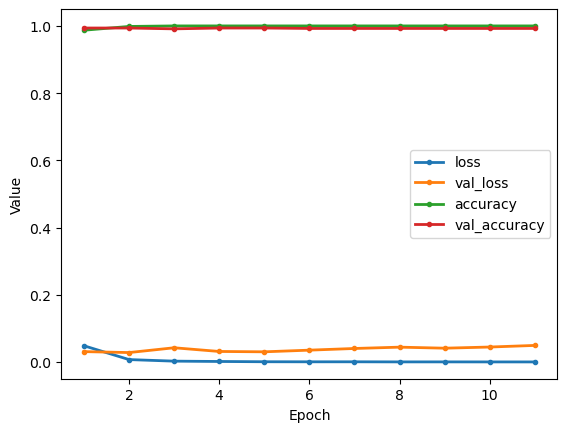

In [19]:
VISU.plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])

In [20]:
VISU.test_report(X_test, y_test, model=model,  args=[model.name, test_scores[1]*100, gene_familly, features_k3, len(dataset)]) 
report.add_report(X_test, y_test, model=model, history=history, args=[model.name, "---"])

 1/32 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 1/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


<h4 style="background-color: #80c4e6; display: flex;">
    <ul><li>k=4</li></ul>
</h4>

In [21]:
k = 4
X, y, features_k4 = DNA.build_kmer_representation_v2(dataset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_test.head()

,AAAA,AAAC,AAAD,AAAE,AAAF,AAAG,AAAH,AAAI,AAAK,AAAL,...,YYYL,YYYM,YYYN,YYYP,YYYQ,YYYR,YYYS,YYYT,YYYV,YYYY
3354,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3820,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3288,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4760,0.011952,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2965,0.000000,0.003472,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [22]:
NUM_CLASS  = 1
SEQ_LENGTH = X_train.shape[1]

* <span style="color: blue; font-weight: bold;">MODEL 2 : FEED-FORWARD NETWORKS</span>

In [23]:
name="FEEDFORWARD_k4"
def feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):
    model = Sequential(name=name)
    model.add(Input(shape=(SEQ_LENGTH,)))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(num_output, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

# Build & train the model
model = feedforward_net1()
stop_callback = early_stopping(patience=10)
save_callback = model_checkpoint(name)

X_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)
history = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])


# Evaluate and score
test_scores = model.evaluate(X_test, y_test, verbose=0)
train_score = history.history.get('accuracy')[-1]
print("\n[Train Accuracy: {:.2f}% - Test Accuracy: {:.2f}%]".format(train_score*100, test_scores[1]*100))

Model: "FEEDFORWARD_k4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_10 (Dense)                     │ (None, 256)                 │      35,989,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 36,030,465 (137.45 MB)

 Trainable params: 36,030,465 (137.45 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 31s 646ms/step - accuracy: 0.5469 - loss: 0.6931

 2/50 ━━━━━━━━━━━━━━━━━━━━ 5s 115ms/step - accuracy: 0.5352 - loss: 0.6932 

 3/50 ━━━━━━━━━━━━━━━━━━━━ 5s 121ms/step - accuracy: 0.5286 - loss: 0.6931

 4/50 ━━━━━━━━━━━━━━━━━━━━ 5s 117ms/step - accuracy: 0.5283 - loss: 0.6930

 5/50 ━━━━━━━━━━━━━━━━━━━━ 5s 115ms/step - accuracy: 0.5233 - loss: 0.6930

 6/50 ━━━━━━━━━━━━━━━━━━━━ 5s 117ms/step - accuracy: 0.5198 - loss: 0.6930

 7/50 ━━━━━━━━━━━━━━━━━━━━ 5s 117ms/step - accuracy: 0.5173 - loss: 0.6929

 8/50 ━━━━━━━━━━━━━━━━━━━━ 4s 118ms/step - accuracy: 0.5166 - loss: 0.6929

 9/50 ━━━━━━━━━━━━━━━━━━━━ 4s 117ms/step - accuracy: 0.5148 - loss: 0.6928

10/50 ━━━━━━━━━━━━━━━━━━━━ 4s 119ms/step - accuracy: 0.5128 - loss: 0.6927

11/50 ━━━━━━━━━━━━━━━━━━━━ 4s 118ms/step - accuracy: 0.5123 - loss: 0.6926

12/50 ━━━━━━━━━━━━━━━━━━━━ 4s 118ms/step - accuracy: 0.5131 - loss: 0.6925

13/50 ━━━━━━━━━━━━━━━━━━━━ 4s 118ms/step - accuracy: 0.5143 - loss: 0.6924

14/50 ━━━━━━━━━━━━━━━━━━━━ 4s 118ms/step - accuracy: 0.5153 - loss: 0.6922

15/50 ━━━━━━━━━━━━━━━━━━━━ 4s 118ms/step - accuracy: 0.5166 - loss: 0.6921

16/50 ━━━━━━━━━━━━━━━━━━━━ 4s 118ms/step - accuracy: 0.5184 - loss: 0.6919

17/50 ━━━━━━━━━━━━━━━━━━━━ 3s 118ms/step - accuracy: 0.5210 - loss: 0.6918

18/50 ━━━━━━━━━━━━━━━━━━━━ 3s 120ms/step - accuracy: 0.5243 - loss: 0.6916

19/50 ━━━━━━━━━━━━━━━━━━━━ 3s 120ms/step - accuracy: 0.5283 - loss: 0.6914

20/50 ━━━━━━━━━━━━━━━━━━━━ 3s 120ms/step - accuracy: 0.5328 - loss: 0.6911

21/50 ━━━━━━━━━━━━━━━━━━━━ 3s 120ms/step - accuracy: 0.5374 - loss: 0.6909

22/50 ━━━━━━━━━━━━━━━━━━━━ 3s 120ms/step - accuracy: 0.5421 - loss: 0.6906

23/50 ━━━━━━━━━━━━━━━━━━━━ 3s 121ms/step - accuracy: 0.5468 - loss: 0.6903

24/50 ━━━━━━━━━━━━━━━━━━━━ 3s 121ms/step - accuracy: 0.5514 - loss: 0.6899

25/50 ━━━━━━━━━━━━━━━━━━━━ 3s 121ms/step - accuracy: 0.5558 - loss: 0.6896

26/50 ━━━━━━━━━━━━━━━━━━━━ 2s 121ms/step - accuracy: 0.5602 - loss: 0.6892

27/50 ━━━━━━━━━━━━━━━━━━━━ 2s 121ms/step - accuracy: 0.5644 - loss: 0.6887

28/50 ━━━━━━━━━━━━━━━━━━━━ 2s 121ms/step - accuracy: 0.5685 - loss: 0.6883

29/50 ━━━━━━━━━━━━━━━━━━━━ 2s 121ms/step - accuracy: 0.5726 - loss: 0.6878

30/50 ━━━━━━━━━━━━━━━━━━━━ 2s 121ms/step - accuracy: 0.5765 - loss: 0.6873

31/50 ━━━━━━━━━━━━━━━━━━━━ 2s 121ms/step - accuracy: 0.5805 - loss: 0.6867

32/50 ━━━━━━━━━━━━━━━━━━━━ 2s 121ms/step - accuracy: 0.5844 - loss: 0.6861

33/50 ━━━━━━━━━━━━━━━━━━━━ 2s 121ms/step - accuracy: 0.5882 - loss: 0.6855

34/50 ━━━━━━━━━━━━━━━━━━━━ 1s 121ms/step - accuracy: 0.5920 - loss: 0.6848

35/50 ━━━━━━━━━━━━━━━━━━━━ 1s 121ms/step - accuracy: 0.5957 - loss: 0.6841

36/50 ━━━━━━━━━━━━━━━━━━━━ 1s 122ms/step - accuracy: 0.5994 - loss: 0.6833

37/50 ━━━━━━━━━━━━━━━━━━━━ 1s 122ms/step - accuracy: 0.6029 - loss: 0.6825

38/50 ━━━━━━━━━━━━━━━━━━━━ 1s 122ms/step - accuracy: 0.6064 - loss: 0.6816

39/50 ━━━━━━━━━━━━━━━━━━━━ 1s 122ms/step - accuracy: 0.6098 - loss: 0.6807

40/50 ━━━━━━━━━━━━━━━━━━━━ 1s 121ms/step - accuracy: 0.6132 - loss: 0.6797

41/50 ━━━━━━━━━━━━━━━━━━━━ 1s 121ms/step - accuracy: 0.6164 - loss: 0.6788

42/50 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - accuracy: 0.6196 - loss: 0.6777

43/50 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - accuracy: 0.6228 - loss: 0.6766

44/50 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - accuracy: 0.6259 - loss: 0.6755

45/50 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - accuracy: 0.6289 - loss: 0.6742

46/50 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - accuracy: 0.6319 - loss: 0.6730

47/50 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - accuracy: 0.6348 - loss: 0.6716

48/50 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - accuracy: 0.6377 - loss: 0.6702

49/50 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - accuracy: 0.6406 - loss: 0.6688

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - accuracy: 0.6434 - loss: 0.6673

50/50 ━━━━━━━━━━━━━━━━━━━━ 9s 161ms/step - accuracy: 0.6461 - loss: 0.6658 - val_accuracy: 0.9312 - val_loss: 0.2847


Epoch 2/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 9s 190ms/step - accuracy: 0.9844 - loss: 0.2361

 2/50 ━━━━━━━━━━━━━━━━━━━━ 6s 129ms/step - accuracy: 0.9844 - loss: 0.2306

 3/50 ━━━━━━━━━━━━━━━━━━━━ 5s 128ms/step - accuracy: 0.9826 - loss: 0.2246

 4/50 ━━━━━━━━━━━━━━━━━━━━ 5s 128ms/step - accuracy: 0.9811 - loss: 0.2213

 5/50 ━━━━━━━━━━━━━━━━━━━━ 5s 128ms/step - accuracy: 0.9799 - loss: 0.2176

 6/50 ━━━━━━━━━━━━━━━━━━━━ 5s 128ms/step - accuracy: 0.9785 - loss: 0.2145

 7/50 ━━━━━━━━━━━━━━━━━━━━ 5s 129ms/step - accuracy: 0.9777 - loss: 0.2112

 8/50 ━━━━━━━━━━━━━━━━━━━━ 5s 129ms/step - accuracy: 0.9773 - loss: 0.2078

 9/50 ━━━━━━━━━━━━━━━━━━━━ 5s 129ms/step - accuracy: 0.9773 - loss: 0.2046

10/50 ━━━━━━━━━━━━━━━━━━━━ 5s 131ms/step - accuracy: 0.9774 - loss: 0.2012

11/50 ━━━━━━━━━━━━━━━━━━━━ 5s 132ms/step - accuracy: 0.9775 - loss: 0.1981

12/50 ━━━━━━━━━━━━━━━━━━━━ 5s 132ms/step - accuracy: 0.9777 - loss: 0.1951

13/50 ━━━━━━━━━━━━━━━━━━━━ 4s 131ms/step - accuracy: 0.9778 - loss: 0.1921

14/50 ━━━━━━━━━━━━━━━━━━━━ 4s 131ms/step - accuracy: 0.9780 - loss: 0.1890

15/50 ━━━━━━━━━━━━━━━━━━━━ 4s 130ms/step - accuracy: 0.9783 - loss: 0.1861

16/50 ━━━━━━━━━━━━━━━━━━━━ 4s 130ms/step - accuracy: 0.9785 - loss: 0.1834

17/50 ━━━━━━━━━━━━━━━━━━━━ 4s 129ms/step - accuracy: 0.9786 - loss: 0.1806

18/50 ━━━━━━━━━━━━━━━━━━━━ 4s 129ms/step - accuracy: 0.9787 - loss: 0.1780

19/50 ━━━━━━━━━━━━━━━━━━━━ 3s 128ms/step - accuracy: 0.9788 - loss: 0.1755

20/50 ━━━━━━━━━━━━━━━━━━━━ 3s 128ms/step - accuracy: 0.9789 - loss: 0.1731

21/50 ━━━━━━━━━━━━━━━━━━━━ 3s 128ms/step - accuracy: 0.9790 - loss: 0.1706

22/50 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - accuracy: 0.9792 - loss: 0.1683

23/50 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - accuracy: 0.9793 - loss: 0.1661

24/50 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - accuracy: 0.9795 - loss: 0.1638

25/50 ━━━━━━━━━━━━━━━━━━━━ 3s 126ms/step - accuracy: 0.9797 - loss: 0.1616

26/50 ━━━━━━━━━━━━━━━━━━━━ 3s 126ms/step - accuracy: 0.9799 - loss: 0.1594

27/50 ━━━━━━━━━━━━━━━━━━━━ 2s 126ms/step - accuracy: 0.9801 - loss: 0.1573

28/50 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - accuracy: 0.9803 - loss: 0.1553

29/50 ━━━━━━━━━━━━━━━━━━━━ 2s 126ms/step - accuracy: 0.9804 - loss: 0.1533

30/50 ━━━━━━━━━━━━━━━━━━━━ 2s 126ms/step - accuracy: 0.9806 - loss: 0.1514

31/50 ━━━━━━━━━━━━━━━━━━━━ 2s 125ms/step - accuracy: 0.9807 - loss: 0.1496

32/50 ━━━━━━━━━━━━━━━━━━━━ 2s 125ms/step - accuracy: 0.9809 - loss: 0.1478

33/50 ━━━━━━━━━━━━━━━━━━━━ 2s 125ms/step - accuracy: 0.9810 - loss: 0.1461

34/50 ━━━━━━━━━━━━━━━━━━━━ 2s 125ms/step - accuracy: 0.9811 - loss: 0.1445

35/50 ━━━━━━━━━━━━━━━━━━━━ 1s 125ms/step - accuracy: 0.9812 - loss: 0.1429

36/50 ━━━━━━━━━━━━━━━━━━━━ 1s 125ms/step - accuracy: 0.9814 - loss: 0.1414

37/50 ━━━━━━━━━━━━━━━━━━━━ 1s 125ms/step - accuracy: 0.9815 - loss: 0.1399

38/50 ━━━━━━━━━━━━━━━━━━━━ 1s 125ms/step - accuracy: 0.9816 - loss: 0.1384

39/50 ━━━━━━━━━━━━━━━━━━━━ 1s 125ms/step - accuracy: 0.9817 - loss: 0.1370

40/50 ━━━━━━━━━━━━━━━━━━━━ 1s 124ms/step - accuracy: 0.9819 - loss: 0.1356

41/50 ━━━━━━━━━━━━━━━━━━━━ 1s 124ms/step - accuracy: 0.9820 - loss: 0.1343

42/50 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 0.9821 - loss: 0.1329

43/50 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 0.9822 - loss: 0.1316

44/50 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 0.9823 - loss: 0.1304

45/50 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 0.9824 - loss: 0.1291

46/50 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 0.9825 - loss: 0.1280

47/50 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 0.9826 - loss: 0.1268

48/50 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 0.9827 - loss: 0.1257

49/50 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - accuracy: 0.9828 - loss: 0.1246

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - accuracy: 0.9829 - loss: 0.1235

50/50 ━━━━━━━━━━━━━━━━━━━━ 8s 155ms/step - accuracy: 0.9830 - loss: 0.1224 - val_accuracy: 0.9912 - val_loss: 0.0325


Epoch 3/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 8s 168ms/step - accuracy: 1.0000 - loss: 0.0042

 2/50 ━━━━━━━━━━━━━━━━━━━━ 5s 119ms/step - accuracy: 1.0000 - loss: 0.0053

 3/50 ━━━━━━━━━━━━━━━━━━━━ 5s 117ms/step - accuracy: 1.0000 - loss: 0.0060

 4/50 ━━━━━━━━━━━━━━━━━━━━ 5s 117ms/step - accuracy: 1.0000 - loss: 0.0063

 5/50 ━━━━━━━━━━━━━━━━━━━━ 5s 116ms/step - accuracy: 1.0000 - loss: 0.0067

 6/50 ━━━━━━━━━━━━━━━━━━━━ 5s 119ms/step - accuracy: 1.0000 - loss: 0.0068

 7/50 ━━━━━━━━━━━━━━━━━━━━ 5s 120ms/step - accuracy: 1.0000 - loss: 0.0069

 8/50 ━━━━━━━━━━━━━━━━━━━━ 5s 120ms/step - accuracy: 1.0000 - loss: 0.0069

 9/50 ━━━━━━━━━━━━━━━━━━━━ 4s 120ms/step - accuracy: 1.0000 - loss: 0.0069

10/50 ━━━━━━━━━━━━━━━━━━━━ 4s 120ms/step - accuracy: 1.0000 - loss: 0.0069

11/50 ━━━━━━━━━━━━━━━━━━━━ 4s 121ms/step - accuracy: 1.0000 - loss: 0.0069

12/50 ━━━━━━━━━━━━━━━━━━━━ 4s 122ms/step - accuracy: 1.0000 - loss: 0.0069

13/50 ━━━━━━━━━━━━━━━━━━━━ 4s 121ms/step - accuracy: 1.0000 - loss: 0.0068

14/50 ━━━━━━━━━━━━━━━━━━━━ 4s 121ms/step - accuracy: 1.0000 - loss: 0.0068

15/50 ━━━━━━━━━━━━━━━━━━━━ 4s 120ms/step - accuracy: 1.0000 - loss: 0.0067

16/50 ━━━━━━━━━━━━━━━━━━━━ 4s 120ms/step - accuracy: 1.0000 - loss: 0.0066

17/50 ━━━━━━━━━━━━━━━━━━━━ 3s 120ms/step - accuracy: 1.0000 - loss: 0.0065

18/50 ━━━━━━━━━━━━━━━━━━━━ 3s 120ms/step - accuracy: 1.0000 - loss: 0.0064

19/50 ━━━━━━━━━━━━━━━━━━━━ 3s 120ms/step - accuracy: 1.0000 - loss: 0.0064

20/50 ━━━━━━━━━━━━━━━━━━━━ 3s 119ms/step - accuracy: 1.0000 - loss: 0.0064

21/50 ━━━━━━━━━━━━━━━━━━━━ 3s 120ms/step - accuracy: 0.9999 - loss: 0.0063

22/50 ━━━━━━━━━━━━━━━━━━━━ 3s 119ms/step - accuracy: 0.9999 - loss: 0.0063

23/50 ━━━━━━━━━━━━━━━━━━━━ 3s 119ms/step - accuracy: 0.9999 - loss: 0.0063

24/50 ━━━━━━━━━━━━━━━━━━━━ 3s 119ms/step - accuracy: 0.9999 - loss: 0.0062

25/50 ━━━━━━━━━━━━━━━━━━━━ 2s 119ms/step - accuracy: 0.9998 - loss: 0.0062

26/50 ━━━━━━━━━━━━━━━━━━━━ 2s 119ms/step - accuracy: 0.9998 - loss: 0.0061

27/50 ━━━━━━━━━━━━━━━━━━━━ 2s 119ms/step - accuracy: 0.9998 - loss: 0.0061

28/50 ━━━━━━━━━━━━━━━━━━━━ 2s 120ms/step - accuracy: 0.9998 - loss: 0.0061

29/50 ━━━━━━━━━━━━━━━━━━━━ 2s 120ms/step - accuracy: 0.9998 - loss: 0.0060

30/50 ━━━━━━━━━━━━━━━━━━━━ 2s 121ms/step - accuracy: 0.9998 - loss: 0.0060

31/50 ━━━━━━━━━━━━━━━━━━━━ 2s 120ms/step - accuracy: 0.9998 - loss: 0.0059

32/50 ━━━━━━━━━━━━━━━━━━━━ 2s 121ms/step - accuracy: 0.9998 - loss: 0.0059

33/50 ━━━━━━━━━━━━━━━━━━━━ 2s 121ms/step - accuracy: 0.9997 - loss: 0.0059

34/50 ━━━━━━━━━━━━━━━━━━━━ 1s 121ms/step - accuracy: 0.9997 - loss: 0.0058

35/50 ━━━━━━━━━━━━━━━━━━━━ 1s 121ms/step - accuracy: 0.9997 - loss: 0.0058

36/50 ━━━━━━━━━━━━━━━━━━━━ 1s 121ms/step - accuracy: 0.9997 - loss: 0.0057

37/50 ━━━━━━━━━━━━━━━━━━━━ 1s 121ms/step - accuracy: 0.9997 - loss: 0.0057

38/50 ━━━━━━━━━━━━━━━━━━━━ 1s 120ms/step - accuracy: 0.9997 - loss: 0.0057

39/50 ━━━━━━━━━━━━━━━━━━━━ 1s 121ms/step - accuracy: 0.9997 - loss: 0.0056

40/50 ━━━━━━━━━━━━━━━━━━━━ 1s 120ms/step - accuracy: 0.9997 - loss: 0.0056

41/50 ━━━━━━━━━━━━━━━━━━━━ 1s 120ms/step - accuracy: 0.9997 - loss: 0.0056

42/50 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - accuracy: 0.9997 - loss: 0.0055

43/50 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - accuracy: 0.9997 - loss: 0.0055

44/50 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - accuracy: 0.9997 - loss: 0.0055

45/50 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - accuracy: 0.9997 - loss: 0.0054

46/50 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - accuracy: 0.9997 - loss: 0.0054

47/50 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - accuracy: 0.9997 - loss: 0.0054

48/50 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - accuracy: 0.9997 - loss: 0.0053

49/50 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - accuracy: 0.9997 - loss: 0.0053

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 0.9997 - loss: 0.0053

50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 131ms/step - accuracy: 0.9997 - loss: 0.0052 - val_accuracy: 0.9912 - val_loss: 0.0307


Epoch 4/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 6s 137ms/step - accuracy: 1.0000 - loss: 0.0012

 2/50 ━━━━━━━━━━━━━━━━━━━━ 5s 109ms/step - accuracy: 1.0000 - loss: 0.0011

 3/50 ━━━━━━━━━━━━━━━━━━━━ 5s 109ms/step - accuracy: 1.0000 - loss: 0.0011

 4/50 ━━━━━━━━━━━━━━━━━━━━ 5s 113ms/step - accuracy: 1.0000 - loss: 0.0011

 5/50 ━━━━━━━━━━━━━━━━━━━━ 5s 113ms/step - accuracy: 1.0000 - loss: 0.0011

 6/50 ━━━━━━━━━━━━━━━━━━━━ 5s 114ms/step - accuracy: 1.0000 - loss: 0.0011

 7/50 ━━━━━━━━━━━━━━━━━━━━ 5s 117ms/step - accuracy: 1.0000 - loss: 0.0011

 8/50 ━━━━━━━━━━━━━━━━━━━━ 4s 116ms/step - accuracy: 1.0000 - loss: 0.0012

 9/50 ━━━━━━━━━━━━━━━━━━━━ 4s 116ms/step - accuracy: 1.0000 - loss: 0.0012

10/50 ━━━━━━━━━━━━━━━━━━━━ 4s 116ms/step - accuracy: 1.0000 - loss: 0.0013

11/50 ━━━━━━━━━━━━━━━━━━━━ 4s 116ms/step - accuracy: 1.0000 - loss: 0.0013

12/50 ━━━━━━━━━━━━━━━━━━━━ 4s 117ms/step - accuracy: 1.0000 - loss: 0.0013

13/50 ━━━━━━━━━━━━━━━━━━━━ 4s 117ms/step - accuracy: 1.0000 - loss: 0.0013

14/50 ━━━━━━━━━━━━━━━━━━━━ 4s 117ms/step - accuracy: 1.0000 - loss: 0.0013

15/50 ━━━━━━━━━━━━━━━━━━━━ 4s 117ms/step - accuracy: 1.0000 - loss: 0.0013

16/50 ━━━━━━━━━━━━━━━━━━━━ 3s 118ms/step - accuracy: 1.0000 - loss: 0.0013

17/50 ━━━━━━━━━━━━━━━━━━━━ 3s 118ms/step - accuracy: 1.0000 - loss: 0.0013

18/50 ━━━━━━━━━━━━━━━━━━━━ 3s 118ms/step - accuracy: 1.0000 - loss: 0.0013

19/50 ━━━━━━━━━━━━━━━━━━━━ 3s 117ms/step - accuracy: 1.0000 - loss: 0.0013

20/50 ━━━━━━━━━━━━━━━━━━━━ 3s 117ms/step - accuracy: 1.0000 - loss: 0.0013

21/50 ━━━━━━━━━━━━━━━━━━━━ 3s 117ms/step - accuracy: 1.0000 - loss: 0.0013

22/50 ━━━━━━━━━━━━━━━━━━━━ 3s 117ms/step - accuracy: 1.0000 - loss: 0.0013

23/50 ━━━━━━━━━━━━━━━━━━━━ 3s 116ms/step - accuracy: 1.0000 - loss: 0.0013

24/50 ━━━━━━━━━━━━━━━━━━━━ 3s 116ms/step - accuracy: 1.0000 - loss: 0.0014

25/50 ━━━━━━━━━━━━━━━━━━━━ 2s 116ms/step - accuracy: 1.0000 - loss: 0.0014

26/50 ━━━━━━━━━━━━━━━━━━━━ 2s 116ms/step - accuracy: 1.0000 - loss: 0.0013

27/50 ━━━━━━━━━━━━━━━━━━━━ 2s 117ms/step - accuracy: 1.0000 - loss: 0.0013

28/50 ━━━━━━━━━━━━━━━━━━━━ 2s 117ms/step - accuracy: 1.0000 - loss: 0.0013

29/50 ━━━━━━━━━━━━━━━━━━━━ 2s 117ms/step - accuracy: 1.0000 - loss: 0.0013

30/50 ━━━━━━━━━━━━━━━━━━━━ 2s 117ms/step - accuracy: 1.0000 - loss: 0.0013

31/50 ━━━━━━━━━━━━━━━━━━━━ 2s 117ms/step - accuracy: 1.0000 - loss: 0.0013

32/50 ━━━━━━━━━━━━━━━━━━━━ 2s 117ms/step - accuracy: 1.0000 - loss: 0.0013

33/50 ━━━━━━━━━━━━━━━━━━━━ 1s 117ms/step - accuracy: 1.0000 - loss: 0.0013

34/50 ━━━━━━━━━━━━━━━━━━━━ 1s 117ms/step - accuracy: 1.0000 - loss: 0.0013

35/50 ━━━━━━━━━━━━━━━━━━━━ 1s 117ms/step - accuracy: 1.0000 - loss: 0.0013

36/50 ━━━━━━━━━━━━━━━━━━━━ 1s 118ms/step - accuracy: 1.0000 - loss: 0.0013

37/50 ━━━━━━━━━━━━━━━━━━━━ 1s 118ms/step - accuracy: 1.0000 - loss: 0.0013

38/50 ━━━━━━━━━━━━━━━━━━━━ 1s 118ms/step - accuracy: 1.0000 - loss: 0.0013

39/50 ━━━━━━━━━━━━━━━━━━━━ 1s 119ms/step - accuracy: 1.0000 - loss: 0.0013

40/50 ━━━━━━━━━━━━━━━━━━━━ 1s 119ms/step - accuracy: 1.0000 - loss: 0.0013

41/50 ━━━━━━━━━━━━━━━━━━━━ 1s 119ms/step - accuracy: 1.0000 - loss: 0.0013

42/50 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - accuracy: 1.0000 - loss: 0.0013

43/50 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - accuracy: 1.0000 - loss: 0.0013

44/50 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - accuracy: 1.0000 - loss: 0.0013

45/50 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - accuracy: 1.0000 - loss: 0.0013

46/50 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 1.0000 - loss: 0.0013

47/50 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 1.0000 - loss: 0.0013

48/50 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 1.0000 - loss: 0.0013

49/50 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 1.0000 - loss: 0.0013

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 1.0000 - loss: 0.0013

50/50 ━━━━━━━━━━━━━━━━━━━━ 6s 125ms/step - accuracy: 1.0000 - loss: 0.0013 - val_accuracy: 0.9875 - val_loss: 0.0361


Epoch 5/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 8s 166ms/step - accuracy: 1.0000 - loss: 5.2151e-04

 2/50 ━━━━━━━━━━━━━━━━━━━━ 5s 116ms/step - accuracy: 1.0000 - loss: 0.0021    

 3/50 ━━━━━━━━━━━━━━━━━━━━ 5s 114ms/step - accuracy: 1.0000 - loss: 0.0023

 4/50 ━━━━━━━━━━━━━━━━━━━━ 5s 115ms/step - accuracy: 1.0000 - loss: 0.0025

 5/50 ━━━━━━━━━━━━━━━━━━━━ 5s 115ms/step - accuracy: 1.0000 - loss: 0.0025

 6/50 ━━━━━━━━━━━━━━━━━━━━ 5s 117ms/step - accuracy: 1.0000 - loss: 0.0025

 7/50 ━━━━━━━━━━━━━━━━━━━━ 5s 120ms/step - accuracy: 1.0000 - loss: 0.0024

 8/50 ━━━━━━━━━━━━━━━━━━━━ 5s 121ms/step - accuracy: 1.0000 - loss: 0.0023

 9/50 ━━━━━━━━━━━━━━━━━━━━ 4s 120ms/step - accuracy: 1.0000 - loss: 0.0023

10/50 ━━━━━━━━━━━━━━━━━━━━ 4s 120ms/step - accuracy: 1.0000 - loss: 0.0022

11/50 ━━━━━━━━━━━━━━━━━━━━ 4s 119ms/step - accuracy: 1.0000 - loss: 0.0021

12/50 ━━━━━━━━━━━━━━━━━━━━ 4s 119ms/step - accuracy: 1.0000 - loss: 0.0021

13/50 ━━━━━━━━━━━━━━━━━━━━ 4s 118ms/step - accuracy: 1.0000 - loss: 0.0020

14/50 ━━━━━━━━━━━━━━━━━━━━ 4s 118ms/step - accuracy: 1.0000 - loss: 0.0020

15/50 ━━━━━━━━━━━━━━━━━━━━ 4s 118ms/step - accuracy: 1.0000 - loss: 0.0020

16/50 ━━━━━━━━━━━━━━━━━━━━ 4s 118ms/step - accuracy: 1.0000 - loss: 0.0019

17/50 ━━━━━━━━━━━━━━━━━━━━ 3s 118ms/step - accuracy: 1.0000 - loss: 0.0019

18/50 ━━━━━━━━━━━━━━━━━━━━ 3s 118ms/step - accuracy: 1.0000 - loss: 0.0019

19/50 ━━━━━━━━━━━━━━━━━━━━ 3s 118ms/step - accuracy: 1.0000 - loss: 0.0019

20/50 ━━━━━━━━━━━━━━━━━━━━ 3s 117ms/step - accuracy: 1.0000 - loss: 0.0018

21/50 ━━━━━━━━━━━━━━━━━━━━ 3s 118ms/step - accuracy: 1.0000 - loss: 0.0018

22/50 ━━━━━━━━━━━━━━━━━━━━ 3s 117ms/step - accuracy: 1.0000 - loss: 0.0018

23/50 ━━━━━━━━━━━━━━━━━━━━ 3s 117ms/step - accuracy: 1.0000 - loss: 0.0018

24/50 ━━━━━━━━━━━━━━━━━━━━ 3s 118ms/step - accuracy: 1.0000 - loss: 0.0017

25/50 ━━━━━━━━━━━━━━━━━━━━ 2s 118ms/step - accuracy: 1.0000 - loss: 0.0017

26/50 ━━━━━━━━━━━━━━━━━━━━ 2s 117ms/step - accuracy: 1.0000 - loss: 0.0017

27/50 ━━━━━━━━━━━━━━━━━━━━ 2s 117ms/step - accuracy: 1.0000 - loss: 0.0017

28/50 ━━━━━━━━━━━━━━━━━━━━ 2s 117ms/step - accuracy: 1.0000 - loss: 0.0017

29/50 ━━━━━━━━━━━━━━━━━━━━ 2s 117ms/step - accuracy: 1.0000 - loss: 0.0016

30/50 ━━━━━━━━━━━━━━━━━━━━ 2s 117ms/step - accuracy: 1.0000 - loss: 0.0016

31/50 ━━━━━━━━━━━━━━━━━━━━ 2s 117ms/step - accuracy: 1.0000 - loss: 0.0016

32/50 ━━━━━━━━━━━━━━━━━━━━ 2s 117ms/step - accuracy: 1.0000 - loss: 0.0016

33/50 ━━━━━━━━━━━━━━━━━━━━ 1s 117ms/step - accuracy: 1.0000 - loss: 0.0016

34/50 ━━━━━━━━━━━━━━━━━━━━ 1s 117ms/step - accuracy: 1.0000 - loss: 0.0016

35/50 ━━━━━━━━━━━━━━━━━━━━ 1s 117ms/step - accuracy: 1.0000 - loss: 0.0015

36/50 ━━━━━━━━━━━━━━━━━━━━ 1s 117ms/step - accuracy: 1.0000 - loss: 0.0015

37/50 ━━━━━━━━━━━━━━━━━━━━ 1s 117ms/step - accuracy: 1.0000 - loss: 0.0015

38/50 ━━━━━━━━━━━━━━━━━━━━ 1s 117ms/step - accuracy: 1.0000 - loss: 0.0015

39/50 ━━━━━━━━━━━━━━━━━━━━ 1s 117ms/step - accuracy: 1.0000 - loss: 0.0015

40/50 ━━━━━━━━━━━━━━━━━━━━ 1s 117ms/step - accuracy: 1.0000 - loss: 0.0015

41/50 ━━━━━━━━━━━━━━━━━━━━ 1s 117ms/step - accuracy: 1.0000 - loss: 0.0015

42/50 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - accuracy: 1.0000 - loss: 0.0014

43/50 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - accuracy: 1.0000 - loss: 0.0014

44/50 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - accuracy: 1.0000 - loss: 0.0014

45/50 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - accuracy: 1.0000 - loss: 0.0014

46/50 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - accuracy: 1.0000 - loss: 0.0014

47/50 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - accuracy: 1.0000 - loss: 0.0014

48/50 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - accuracy: 1.0000 - loss: 0.0014

49/50 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - accuracy: 1.0000 - loss: 0.0014

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - accuracy: 1.0000 - loss: 0.0014

50/50 ━━━━━━━━━━━━━━━━━━━━ 6s 123ms/step - accuracy: 1.0000 - loss: 0.0013 - val_accuracy: 0.9862 - val_loss: 0.0407


Epoch 6/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 8s 166ms/step - accuracy: 1.0000 - loss: 4.9570e-04

 2/50 ━━━━━━━━━━━━━━━━━━━━ 5s 108ms/step - accuracy: 1.0000 - loss: 4.4355e-04

 3/50 ━━━━━━━━━━━━━━━━━━━━ 5s 110ms/step - accuracy: 1.0000 - loss: 4.3354e-04

 4/50 ━━━━━━━━━━━━━━━━━━━━ 5s 117ms/step - accuracy: 1.0000 - loss: 4.2894e-04

 5/50 ━━━━━━━━━━━━━━━━━━━━ 5s 116ms/step - accuracy: 1.0000 - loss: 4.1909e-04

 6/50 ━━━━━━━━━━━━━━━━━━━━ 5s 114ms/step - accuracy: 1.0000 - loss: 4.0833e-04

 7/50 ━━━━━━━━━━━━━━━━━━━━ 4s 113ms/step - accuracy: 1.0000 - loss: 4.0005e-04

 8/50 ━━━━━━━━━━━━━━━━━━━━ 4s 113ms/step - accuracy: 1.0000 - loss: 3.9503e-04

 9/50 ━━━━━━━━━━━━━━━━━━━━ 4s 113ms/step - accuracy: 1.0000 - loss: 3.9269e-04

10/50 ━━━━━━━━━━━━━━━━━━━━ 4s 113ms/step - accuracy: 1.0000 - loss: 3.9450e-04

11/50 ━━━━━━━━━━━━━━━━━━━━ 4s 113ms/step - accuracy: 1.0000 - loss: 3.9580e-04

12/50 ━━━━━━━━━━━━━━━━━━━━ 4s 114ms/step - accuracy: 1.0000 - loss: 3.9625e-04

13/50 ━━━━━━━━━━━━━━━━━━━━ 4s 114ms/step - accuracy: 1.0000 - loss: 3.9594e-04

14/50 ━━━━━━━━━━━━━━━━━━━━ 4s 114ms/step - accuracy: 1.0000 - loss: 3.9562e-04

15/50 ━━━━━━━━━━━━━━━━━━━━ 3s 114ms/step - accuracy: 1.0000 - loss: 3.9434e-04

16/50 ━━━━━━━━━━━━━━━━━━━━ 4s 121ms/step - accuracy: 1.0000 - loss: 3.9254e-04

17/50 ━━━━━━━━━━━━━━━━━━━━ 4s 124ms/step - accuracy: 1.0000 - loss: 3.9104e-04

18/50 ━━━━━━━━━━━━━━━━━━━━ 3s 123ms/step - accuracy: 1.0000 - loss: 3.8924e-04

19/50 ━━━━━━━━━━━━━━━━━━━━ 3s 123ms/step - accuracy: 1.0000 - loss: 3.8750e-04

20/50 ━━━━━━━━━━━━━━━━━━━━ 3s 122ms/step - accuracy: 1.0000 - loss: 3.8614e-04

21/50 ━━━━━━━━━━━━━━━━━━━━ 3s 122ms/step - accuracy: 1.0000 - loss: 3.8474e-04

22/50 ━━━━━━━━━━━━━━━━━━━━ 3s 122ms/step - accuracy: 1.0000 - loss: 3.8368e-04

23/50 ━━━━━━━━━━━━━━━━━━━━ 3s 122ms/step - accuracy: 1.0000 - loss: 3.8249e-04

24/50 ━━━━━━━━━━━━━━━━━━━━ 3s 122ms/step - accuracy: 1.0000 - loss: 3.8115e-04

25/50 ━━━━━━━━━━━━━━━━━━━━ 3s 121ms/step - accuracy: 1.0000 - loss: 3.7977e-04

26/50 ━━━━━━━━━━━━━━━━━━━━ 2s 121ms/step - accuracy: 1.0000 - loss: 3.7826e-04

27/50 ━━━━━━━━━━━━━━━━━━━━ 2s 121ms/step - accuracy: 1.0000 - loss: 3.7673e-04

28/50 ━━━━━━━━━━━━━━━━━━━━ 2s 121ms/step - accuracy: 1.0000 - loss: 3.7550e-04

29/50 ━━━━━━━━━━━━━━━━━━━━ 2s 121ms/step - accuracy: 1.0000 - loss: 3.7436e-04

30/50 ━━━━━━━━━━━━━━━━━━━━ 2s 121ms/step - accuracy: 1.0000 - loss: 3.7312e-04

31/50 ━━━━━━━━━━━━━━━━━━━━ 2s 121ms/step - accuracy: 1.0000 - loss: 3.7180e-04

32/50 ━━━━━━━━━━━━━━━━━━━━ 2s 120ms/step - accuracy: 1.0000 - loss: 3.7046e-04

33/50 ━━━━━━━━━━━━━━━━━━━━ 2s 120ms/step - accuracy: 1.0000 - loss: 3.6918e-04

34/50 ━━━━━━━━━━━━━━━━━━━━ 1s 120ms/step - accuracy: 1.0000 - loss: 3.6817e-04

35/50 ━━━━━━━━━━━━━━━━━━━━ 1s 120ms/step - accuracy: 1.0000 - loss: 3.6709e-04

36/50 ━━━━━━━━━━━━━━━━━━━━ 1s 120ms/step - accuracy: 1.0000 - loss: 3.6600e-04

37/50 ━━━━━━━━━━━━━━━━━━━━ 1s 121ms/step - accuracy: 1.0000 - loss: 3.6484e-04

38/50 ━━━━━━━━━━━━━━━━━━━━ 1s 120ms/step - accuracy: 1.0000 - loss: 3.6376e-04

39/50 ━━━━━━━━━━━━━━━━━━━━ 1s 121ms/step - accuracy: 1.0000 - loss: 3.6282e-04

40/50 ━━━━━━━━━━━━━━━━━━━━ 1s 121ms/step - accuracy: 1.0000 - loss: 3.6191e-04

41/50 ━━━━━━━━━━━━━━━━━━━━ 1s 120ms/step - accuracy: 1.0000 - loss: 3.6098e-04

42/50 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - accuracy: 1.0000 - loss: 3.6020e-04

43/50 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - accuracy: 1.0000 - loss: 3.5965e-04

44/50 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - accuracy: 1.0000 - loss: 3.5913e-04

45/50 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - accuracy: 1.0000 - loss: 3.5858e-04

46/50 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - accuracy: 1.0000 - loss: 3.5797e-04

47/50 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - accuracy: 1.0000 - loss: 3.5733e-04

48/50 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - accuracy: 1.0000 - loss: 3.5667e-04

49/50 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - accuracy: 1.0000 - loss: 3.5598e-04

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - accuracy: 1.0000 - loss: 3.5537e-04

50/50 ━━━━━━━━━━━━━━━━━━━━ 6s 126ms/step - accuracy: 1.0000 - loss: 3.5479e-04 - val_accuracy: 0.9862 - val_loss: 0.0399


Epoch 7/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 10s 212ms/step - accuracy: 1.0000 - loss: 2.6328e-04

 2/50 ━━━━━━━━━━━━━━━━━━━━ 5s 119ms/step - accuracy: 1.0000 - loss: 2.5352e-04 

 3/50 ━━━━━━━━━━━━━━━━━━━━ 5s 123ms/step - accuracy: 1.0000 - loss: 2.3870e-04

 4/50 ━━━━━━━━━━━━━━━━━━━━ 5s 117ms/step - accuracy: 1.0000 - loss: 2.2678e-04

 5/50 ━━━━━━━━━━━━━━━━━━━━ 5s 116ms/step - accuracy: 1.0000 - loss: 2.3855e-04

 6/50 ━━━━━━━━━━━━━━━━━━━━ 5s 120ms/step - accuracy: 1.0000 - loss: 2.4397e-04

 7/50 ━━━━━━━━━━━━━━━━━━━━ 5s 122ms/step - accuracy: 1.0000 - loss: 2.4731e-04

 8/50 ━━━━━━━━━━━━━━━━━━━━ 5s 124ms/step - accuracy: 1.0000 - loss: 2.5030e-04

 9/50 ━━━━━━━━━━━━━━━━━━━━ 5s 123ms/step - accuracy: 1.0000 - loss: 2.5061e-04

10/50 ━━━━━━━━━━━━━━━━━━━━ 4s 123ms/step - accuracy: 1.0000 - loss: 2.4938e-04

11/50 ━━━━━━━━━━━━━━━━━━━━ 4s 122ms/step - accuracy: 1.0000 - loss: 2.4876e-04

12/50 ━━━━━━━━━━━━━━━━━━━━ 4s 123ms/step - accuracy: 1.0000 - loss: 2.4763e-04

13/50 ━━━━━━━━━━━━━━━━━━━━ 4s 122ms/step - accuracy: 1.0000 - loss: 2.4640e-04

14/50 ━━━━━━━━━━━━━━━━━━━━ 4s 121ms/step - accuracy: 1.0000 - loss: 2.4472e-04

15/50 ━━━━━━━━━━━━━━━━━━━━ 4s 121ms/step - accuracy: 1.0000 - loss: 2.4303e-04

16/50 ━━━━━━━━━━━━━━━━━━━━ 4s 120ms/step - accuracy: 1.0000 - loss: 2.4117e-04

17/50 ━━━━━━━━━━━━━━━━━━━━ 3s 120ms/step - accuracy: 1.0000 - loss: 2.3924e-04

18/50 ━━━━━━━━━━━━━━━━━━━━ 3s 120ms/step - accuracy: 1.0000 - loss: 2.3766e-04

19/50 ━━━━━━━━━━━━━━━━━━━━ 3s 120ms/step - accuracy: 1.0000 - loss: 2.3643e-04

20/50 ━━━━━━━━━━━━━━━━━━━━ 3s 120ms/step - accuracy: 1.0000 - loss: 2.3511e-04

21/50 ━━━━━━━━━━━━━━━━━━━━ 3s 121ms/step - accuracy: 1.0000 - loss: 2.3391e-04

22/50 ━━━━━━━━━━━━━━━━━━━━ 3s 120ms/step - accuracy: 1.0000 - loss: 2.3289e-04

23/50 ━━━━━━━━━━━━━━━━━━━━ 3s 120ms/step - accuracy: 1.0000 - loss: 2.3240e-04

24/50 ━━━━━━━━━━━━━━━━━━━━ 3s 120ms/step - accuracy: 1.0000 - loss: 2.3209e-04

25/50 ━━━━━━━━━━━━━━━━━━━━ 2s 120ms/step - accuracy: 1.0000 - loss: 2.3173e-04

26/50 ━━━━━━━━━━━━━━━━━━━━ 2s 120ms/step - accuracy: 1.0000 - loss: 2.3133e-04

27/50 ━━━━━━━━━━━━━━━━━━━━ 2s 120ms/step - accuracy: 1.0000 - loss: 2.3084e-04

28/50 ━━━━━━━━━━━━━━━━━━━━ 2s 120ms/step - accuracy: 1.0000 - loss: 2.3057e-04

29/50 ━━━━━━━━━━━━━━━━━━━━ 2s 120ms/step - accuracy: 1.0000 - loss: 2.3020e-04

30/50 ━━━━━━━━━━━━━━━━━━━━ 2s 120ms/step - accuracy: 1.0000 - loss: 2.2970e-04

31/50 ━━━━━━━━━━━━━━━━━━━━ 2s 120ms/step - accuracy: 1.0000 - loss: 2.2910e-04

32/50 ━━━━━━━━━━━━━━━━━━━━ 2s 120ms/step - accuracy: 1.0000 - loss: 2.2870e-04

33/50 ━━━━━━━━━━━━━━━━━━━━ 2s 120ms/step - accuracy: 1.0000 - loss: 2.2834e-04

34/50 ━━━━━━━━━━━━━━━━━━━━ 1s 120ms/step - accuracy: 1.0000 - loss: 2.2804e-04

35/50 ━━━━━━━━━━━━━━━━━━━━ 1s 119ms/step - accuracy: 1.0000 - loss: 2.2767e-04

36/50 ━━━━━━━━━━━━━━━━━━━━ 1s 119ms/step - accuracy: 1.0000 - loss: 2.2732e-04

37/50 ━━━━━━━━━━━━━━━━━━━━ 1s 119ms/step - accuracy: 1.0000 - loss: 2.2715e-04

38/50 ━━━━━━━━━━━━━━━━━━━━ 1s 119ms/step - accuracy: 1.0000 - loss: 2.2693e-04

39/50 ━━━━━━━━━━━━━━━━━━━━ 1s 119ms/step - accuracy: 1.0000 - loss: 2.2668e-04

40/50 ━━━━━━━━━━━━━━━━━━━━ 1s 119ms/step - accuracy: 1.0000 - loss: 2.2644e-04

41/50 ━━━━━━━━━━━━━━━━━━━━ 1s 119ms/step - accuracy: 1.0000 - loss: 2.2619e-04

42/50 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 1.0000 - loss: 2.2609e-04

43/50 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 1.0000 - loss: 2.2592e-04

44/50 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 1.0000 - loss: 2.2572e-04

45/50 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 1.0000 - loss: 2.2546e-04

46/50 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 1.0000 - loss: 2.2516e-04

47/50 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 1.0000 - loss: 2.2482e-04

48/50 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 1.0000 - loss: 2.2446e-04

49/50 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 1.0000 - loss: 2.2407e-04

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 1.0000 - loss: 2.2367e-04

50/50 ━━━━━━━━━━━━━━━━━━━━ 6s 124ms/step - accuracy: 1.0000 - loss: 2.2329e-04 - val_accuracy: 0.9862 - val_loss: 0.0413


Epoch 8/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 7s 158ms/step - accuracy: 1.0000 - loss: 9.8239e-05

 2/50 ━━━━━━━━━━━━━━━━━━━━ 5s 113ms/step - accuracy: 1.0000 - loss: 9.0653e-05

 3/50 ━━━━━━━━━━━━━━━━━━━━ 5s 110ms/step - accuracy: 1.0000 - loss: 8.8596e-05

 4/50 ━━━━━━━━━━━━━━━━━━━━ 5s 112ms/step - accuracy: 1.0000 - loss: 8.9119e-05

 5/50 ━━━━━━━━━━━━━━━━━━━━ 5s 114ms/step - accuracy: 1.0000 - loss: 9.1598e-05

 6/50 ━━━━━━━━━━━━━━━━━━━━ 4s 114ms/step - accuracy: 1.0000 - loss: 9.2727e-05

 7/50 ━━━━━━━━━━━━━━━━━━━━ 4s 113ms/step - accuracy: 1.0000 - loss: 9.5064e-05

 8/50 ━━━━━━━━━━━━━━━━━━━━ 4s 114ms/step - accuracy: 1.0000 - loss: 9.6743e-05

 9/50 ━━━━━━━━━━━━━━━━━━━━ 4s 115ms/step - accuracy: 1.0000 - loss: 9.8048e-05

10/50 ━━━━━━━━━━━━━━━━━━━━ 4s 117ms/step - accuracy: 1.0000 - loss: 9.9804e-05

11/50 ━━━━━━━━━━━━━━━━━━━━ 4s 117ms/step - accuracy: 1.0000 - loss: 1.0125e-04

12/50 ━━━━━━━━━━━━━━━━━━━━ 4s 116ms/step - accuracy: 1.0000 - loss: 1.0235e-04

13/50 ━━━━━━━━━━━━━━━━━━━━ 4s 116ms/step - accuracy: 1.0000 - loss: 1.0448e-04

14/50 ━━━━━━━━━━━━━━━━━━━━ 4s 117ms/step - accuracy: 1.0000 - loss: 1.0643e-04

15/50 ━━━━━━━━━━━━━━━━━━━━ 4s 117ms/step - accuracy: 1.0000 - loss: 1.0835e-04

16/50 ━━━━━━━━━━━━━━━━━━━━ 3s 117ms/step - accuracy: 1.0000 - loss: 1.1039e-04

17/50 ━━━━━━━━━━━━━━━━━━━━ 3s 116ms/step - accuracy: 1.0000 - loss: 1.1224e-04

18/50 ━━━━━━━━━━━━━━━━━━━━ 3s 118ms/step - accuracy: 1.0000 - loss: 1.1380e-04

19/50 ━━━━━━━━━━━━━━━━━━━━ 3s 118ms/step - accuracy: 1.0000 - loss: 1.1521e-04

20/50 ━━━━━━━━━━━━━━━━━━━━ 3s 118ms/step - accuracy: 1.0000 - loss: 1.1855e-04

21/50 ━━━━━━━━━━━━━━━━━━━━ 3s 118ms/step - accuracy: 1.0000 - loss: 1.2150e-04

22/50 ━━━━━━━━━━━━━━━━━━━━ 3s 118ms/step - accuracy: 1.0000 - loss: 1.2397e-04

23/50 ━━━━━━━━━━━━━━━━━━━━ 3s 118ms/step - accuracy: 1.0000 - loss: 1.2612e-04

24/50 ━━━━━━━━━━━━━━━━━━━━ 3s 118ms/step - accuracy: 1.0000 - loss: 1.2793e-04

25/50 ━━━━━━━━━━━━━━━━━━━━ 2s 118ms/step - accuracy: 1.0000 - loss: 1.2946e-04

26/50 ━━━━━━━━━━━━━━━━━━━━ 2s 118ms/step - accuracy: 1.0000 - loss: 1.3084e-04

27/50 ━━━━━━━━━━━━━━━━━━━━ 2s 118ms/step - accuracy: 1.0000 - loss: 1.3203e-04

28/50 ━━━━━━━━━━━━━━━━━━━━ 2s 117ms/step - accuracy: 1.0000 - loss: 1.3434e-04

29/50 ━━━━━━━━━━━━━━━━━━━━ 2s 118ms/step - accuracy: 1.0000 - loss: 1.3643e-04

30/50 ━━━━━━━━━━━━━━━━━━━━ 2s 118ms/step - accuracy: 1.0000 - loss: 1.3888e-04

31/50 ━━━━━━━━━━━━━━━━━━━━ 2s 118ms/step - accuracy: 1.0000 - loss: 1.4112e-04

32/50 ━━━━━━━━━━━━━━━━━━━━ 2s 118ms/step - accuracy: 1.0000 - loss: 1.4312e-04

33/50 ━━━━━━━━━━━━━━━━━━━━ 1s 118ms/step - accuracy: 1.0000 - loss: 1.4527e-04

34/50 ━━━━━━━━━━━━━━━━━━━━ 1s 118ms/step - accuracy: 1.0000 - loss: 1.4717e-04

35/50 ━━━━━━━━━━━━━━━━━━━━ 1s 118ms/step - accuracy: 1.0000 - loss: 1.4908e-04

36/50 ━━━━━━━━━━━━━━━━━━━━ 1s 117ms/step - accuracy: 1.0000 - loss: 1.5081e-04

37/50 ━━━━━━━━━━━━━━━━━━━━ 1s 117ms/step - accuracy: 1.0000 - loss: 1.5239e-04

38/50 ━━━━━━━━━━━━━━━━━━━━ 1s 117ms/step - accuracy: 1.0000 - loss: 1.5385e-04

39/50 ━━━━━━━━━━━━━━━━━━━━ 1s 117ms/step - accuracy: 1.0000 - loss: 1.5519e-04

40/50 ━━━━━━━━━━━━━━━━━━━━ 1s 117ms/step - accuracy: 1.0000 - loss: 1.5640e-04

41/50 ━━━━━━━━━━━━━━━━━━━━ 1s 117ms/step - accuracy: 1.0000 - loss: 1.5751e-04

42/50 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - accuracy: 1.0000 - loss: 1.5854e-04

43/50 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - accuracy: 1.0000 - loss: 1.5955e-04

44/50 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - accuracy: 1.0000 - loss: 1.6046e-04

45/50 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - accuracy: 1.0000 - loss: 1.6128e-04

46/50 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - accuracy: 1.0000 - loss: 1.6204e-04

47/50 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - accuracy: 1.0000 - loss: 1.6274e-04

48/50 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - accuracy: 1.0000 - loss: 1.6349e-04

49/50 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - accuracy: 1.0000 - loss: 1.6422e-04

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - accuracy: 1.0000 - loss: 1.6491e-04

50/50 ━━━━━━━━━━━━━━━━━━━━ 6s 122ms/step - accuracy: 1.0000 - loss: 1.6558e-04 - val_accuracy: 0.9887 - val_loss: 0.0356


Epoch 9/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 7s 154ms/step - accuracy: 1.0000 - loss: 1.4360e-04

 2/50 ━━━━━━━━━━━━━━━━━━━━ 4s 104ms/step - accuracy: 1.0000 - loss: 1.4474e-04

 3/50 ━━━━━━━━━━━━━━━━━━━━ 5s 107ms/step - accuracy: 1.0000 - loss: 1.7173e-04

 4/50 ━━━━━━━━━━━━━━━━━━━━ 4s 108ms/step - accuracy: 1.0000 - loss: 1.7746e-04

 5/50 ━━━━━━━━━━━━━━━━━━━━ 4s 107ms/step - accuracy: 1.0000 - loss: 1.7695e-04

 6/50 ━━━━━━━━━━━━━━━━━━━━ 4s 106ms/step - accuracy: 1.0000 - loss: 1.7768e-04

 7/50 ━━━━━━━━━━━━━━━━━━━━ 4s 108ms/step - accuracy: 1.0000 - loss: 1.7637e-04

 8/50 ━━━━━━━━━━━━━━━━━━━━ 4s 109ms/step - accuracy: 1.0000 - loss: 1.7555e-04

 9/50 ━━━━━━━━━━━━━━━━━━━━ 4s 109ms/step - accuracy: 1.0000 - loss: 1.7424e-04

10/50 ━━━━━━━━━━━━━━━━━━━━ 4s 111ms/step - accuracy: 1.0000 - loss: 1.7202e-04

11/50 ━━━━━━━━━━━━━━━━━━━━ 4s 112ms/step - accuracy: 1.0000 - loss: 1.7105e-04

12/50 ━━━━━━━━━━━━━━━━━━━━ 4s 113ms/step - accuracy: 1.0000 - loss: 1.7035e-04

13/50 ━━━━━━━━━━━━━━━━━━━━ 4s 113ms/step - accuracy: 1.0000 - loss: 1.7000e-04

14/50 ━━━━━━━━━━━━━━━━━━━━ 4s 113ms/step - accuracy: 1.0000 - loss: 1.6927e-04

15/50 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - accuracy: 1.0000 - loss: 1.6837e-04

16/50 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - accuracy: 1.0000 - loss: 1.6725e-04

17/50 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - accuracy: 1.0000 - loss: 1.6626e-04

18/50 ━━━━━━━━━━━━━━━━━━━━ 3s 114ms/step - accuracy: 1.0000 - loss: 1.6512e-04

19/50 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - accuracy: 1.0000 - loss: 1.6394e-04

20/50 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - accuracy: 1.0000 - loss: 1.6278e-04

21/50 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - accuracy: 1.0000 - loss: 1.6189e-04

22/50 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - accuracy: 1.0000 - loss: 1.6100e-04

23/50 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - accuracy: 1.0000 - loss: 1.6001e-04

24/50 ━━━━━━━━━━━━━━━━━━━━ 2s 114ms/step - accuracy: 1.0000 - loss: 1.5902e-04

25/50 ━━━━━━━━━━━━━━━━━━━━ 2s 114ms/step - accuracy: 1.0000 - loss: 1.5808e-04

26/50 ━━━━━━━━━━━━━━━━━━━━ 2s 114ms/step - accuracy: 1.0000 - loss: 1.5713e-04

27/50 ━━━━━━━━━━━━━━━━━━━━ 2s 114ms/step - accuracy: 1.0000 - loss: 1.5614e-04

28/50 ━━━━━━━━━━━━━━━━━━━━ 2s 113ms/step - accuracy: 1.0000 - loss: 1.5516e-04

29/50 ━━━━━━━━━━━━━━━━━━━━ 2s 114ms/step - accuracy: 1.0000 - loss: 1.5412e-04

30/50 ━━━━━━━━━━━━━━━━━━━━ 2s 113ms/step - accuracy: 1.0000 - loss: 1.5314e-04

31/50 ━━━━━━━━━━━━━━━━━━━━ 2s 113ms/step - accuracy: 1.0000 - loss: 1.5220e-04

32/50 ━━━━━━━━━━━━━━━━━━━━ 2s 114ms/step - accuracy: 1.0000 - loss: 1.5130e-04

33/50 ━━━━━━━━━━━━━━━━━━━━ 1s 114ms/step - accuracy: 1.0000 - loss: 1.5039e-04

34/50 ━━━━━━━━━━━━━━━━━━━━ 1s 114ms/step - accuracy: 1.0000 - loss: 1.4949e-04

35/50 ━━━━━━━━━━━━━━━━━━━━ 1s 114ms/step - accuracy: 1.0000 - loss: 1.4858e-04

36/50 ━━━━━━━━━━━━━━━━━━━━ 1s 114ms/step - accuracy: 1.0000 - loss: 1.4767e-04

37/50 ━━━━━━━━━━━━━━━━━━━━ 1s 114ms/step - accuracy: 1.0000 - loss: 1.4675e-04

38/50 ━━━━━━━━━━━━━━━━━━━━ 1s 114ms/step - accuracy: 1.0000 - loss: 1.4589e-04

39/50 ━━━━━━━━━━━━━━━━━━━━ 1s 115ms/step - accuracy: 1.0000 - loss: 1.4515e-04

40/50 ━━━━━━━━━━━━━━━━━━━━ 1s 115ms/step - accuracy: 1.0000 - loss: 1.4440e-04

41/50 ━━━━━━━━━━━━━━━━━━━━ 1s 114ms/step - accuracy: 1.0000 - loss: 1.4365e-04

42/50 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - accuracy: 1.0000 - loss: 1.4290e-04

43/50 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - accuracy: 1.0000 - loss: 1.4221e-04

44/50 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - accuracy: 1.0000 - loss: 1.4153e-04

45/50 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - accuracy: 1.0000 - loss: 1.4084e-04

46/50 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - accuracy: 1.0000 - loss: 1.4021e-04

47/50 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - accuracy: 1.0000 - loss: 1.3960e-04

48/50 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - accuracy: 1.0000 - loss: 1.3901e-04

49/50 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - accuracy: 1.0000 - loss: 1.3841e-04

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - accuracy: 1.0000 - loss: 1.3780e-04

50/50 ━━━━━━━━━━━━━━━━━━━━ 6s 121ms/step - accuracy: 1.0000 - loss: 1.3722e-04 - val_accuracy: 0.9862 - val_loss: 0.0480


Epoch 10/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 8s 183ms/step - accuracy: 1.0000 - loss: 5.9217e-05

 2/50 ━━━━━━━━━━━━━━━━━━━━ 5s 119ms/step - accuracy: 1.0000 - loss: 5.8617e-05

 3/50 ━━━━━━━━━━━━━━━━━━━━ 5s 117ms/step - accuracy: 1.0000 - loss: 6.0377e-05

 4/50 ━━━━━━━━━━━━━━━━━━━━ 5s 118ms/step - accuracy: 1.0000 - loss: 6.0380e-05

 5/50 ━━━━━━━━━━━━━━━━━━━━ 5s 116ms/step - accuracy: 1.0000 - loss: 6.0326e-05

 6/50 ━━━━━━━━━━━━━━━━━━━━ 5s 116ms/step - accuracy: 1.0000 - loss: 6.1214e-05

 7/50 ━━━━━━━━━━━━━━━━━━━━ 4s 115ms/step - accuracy: 1.0000 - loss: 6.1979e-05

 8/50 ━━━━━━━━━━━━━━━━━━━━ 4s 117ms/step - accuracy: 1.0000 - loss: 6.2863e-05

 9/50 ━━━━━━━━━━━━━━━━━━━━ 4s 117ms/step - accuracy: 1.0000 - loss: 6.3826e-05

10/50 ━━━━━━━━━━━━━━━━━━━━ 4s 118ms/step - accuracy: 1.0000 - loss: 6.5615e-05

11/50 ━━━━━━━━━━━━━━━━━━━━ 4s 116ms/step - accuracy: 1.0000 - loss: 6.6993e-05

12/50 ━━━━━━━━━━━━━━━━━━━━ 4s 117ms/step - accuracy: 1.0000 - loss: 6.8158e-05

13/50 ━━━━━━━━━━━━━━━━━━━━ 4s 116ms/step - accuracy: 1.0000 - loss: 6.9422e-05

14/50 ━━━━━━━━━━━━━━━━━━━━ 4s 116ms/step - accuracy: 1.0000 - loss: 7.0371e-05

15/50 ━━━━━━━━━━━━━━━━━━━━ 4s 117ms/step - accuracy: 1.0000 - loss: 7.1224e-05

16/50 ━━━━━━━━━━━━━━━━━━━━ 3s 117ms/step - accuracy: 1.0000 - loss: 7.2026e-05

17/50 ━━━━━━━━━━━━━━━━━━━━ 3s 117ms/step - accuracy: 1.0000 - loss: 7.2787e-05

18/50 ━━━━━━━━━━━━━━━━━━━━ 3s 116ms/step - accuracy: 1.0000 - loss: 7.3484e-05

19/50 ━━━━━━━━━━━━━━━━━━━━ 3s 116ms/step - accuracy: 1.0000 - loss: 7.3986e-05

20/50 ━━━━━━━━━━━━━━━━━━━━ 3s 116ms/step - accuracy: 1.0000 - loss: 7.4596e-05

21/50 ━━━━━━━━━━━━━━━━━━━━ 3s 116ms/step - accuracy: 1.0000 - loss: 7.5096e-05

22/50 ━━━━━━━━━━━━━━━━━━━━ 3s 116ms/step - accuracy: 1.0000 - loss: 7.5620e-05

23/50 ━━━━━━━━━━━━━━━━━━━━ 3s 116ms/step - accuracy: 1.0000 - loss: 7.6182e-05

24/50 ━━━━━━━━━━━━━━━━━━━━ 3s 116ms/step - accuracy: 1.0000 - loss: 7.6598e-05

25/50 ━━━━━━━━━━━━━━━━━━━━ 2s 116ms/step - accuracy: 1.0000 - loss: 7.6950e-05

26/50 ━━━━━━━━━━━━━━━━━━━━ 2s 117ms/step - accuracy: 1.0000 - loss: 7.7350e-05

27/50 ━━━━━━━━━━━━━━━━━━━━ 2s 117ms/step - accuracy: 1.0000 - loss: 7.7688e-05

28/50 ━━━━━━━━━━━━━━━━━━━━ 2s 117ms/step - accuracy: 1.0000 - loss: 7.8187e-05

29/50 ━━━━━━━━━━━━━━━━━━━━ 2s 117ms/step - accuracy: 1.0000 - loss: 7.8736e-05

30/50 ━━━━━━━━━━━━━━━━━━━━ 2s 117ms/step - accuracy: 1.0000 - loss: 7.9289e-05

31/50 ━━━━━━━━━━━━━━━━━━━━ 2s 117ms/step - accuracy: 1.0000 - loss: 7.9854e-05

32/50 ━━━━━━━━━━━━━━━━━━━━ 2s 117ms/step - accuracy: 1.0000 - loss: 8.0382e-05

33/50 ━━━━━━━━━━━━━━━━━━━━ 1s 117ms/step - accuracy: 1.0000 - loss: 8.0843e-05

34/50 ━━━━━━━━━━━━━━━━━━━━ 1s 116ms/step - accuracy: 1.0000 - loss: 8.1243e-05

35/50 ━━━━━━━━━━━━━━━━━━━━ 1s 116ms/step - accuracy: 1.0000 - loss: 8.1634e-05

36/50 ━━━━━━━━━━━━━━━━━━━━ 1s 116ms/step - accuracy: 1.0000 - loss: 8.2051e-05

37/50 ━━━━━━━━━━━━━━━━━━━━ 1s 116ms/step - accuracy: 1.0000 - loss: 8.2413e-05

38/50 ━━━━━━━━━━━━━━━━━━━━ 1s 116ms/step - accuracy: 1.0000 - loss: 8.2744e-05

39/50 ━━━━━━━━━━━━━━━━━━━━ 1s 116ms/step - accuracy: 1.0000 - loss: 8.3015e-05

40/50 ━━━━━━━━━━━━━━━━━━━━ 1s 116ms/step - accuracy: 1.0000 - loss: 8.3275e-05

41/50 ━━━━━━━━━━━━━━━━━━━━ 1s 116ms/step - accuracy: 1.0000 - loss: 8.3503e-05

42/50 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - accuracy: 1.0000 - loss: 8.3728e-05

43/50 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - accuracy: 1.0000 - loss: 8.3936e-05

44/50 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - accuracy: 1.0000 - loss: 8.4125e-05

45/50 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - accuracy: 1.0000 - loss: 8.4283e-05

46/50 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - accuracy: 1.0000 - loss: 8.4411e-05

47/50 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - accuracy: 1.0000 - loss: 8.4516e-05

48/50 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - accuracy: 1.0000 - loss: 8.4594e-05

49/50 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - accuracy: 1.0000 - loss: 8.5112e-05

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - accuracy: 1.0000 - loss: 8.5585e-05

50/50 ━━━━━━━━━━━━━━━━━━━━ 6s 122ms/step - accuracy: 1.0000 - loss: 8.6040e-05 - val_accuracy: 0.9862 - val_loss: 0.0468


Epoch 11/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 9s 189ms/step - accuracy: 1.0000 - loss: 5.1911e-05

 2/50 ━━━━━━━━━━━━━━━━━━━━ 5s 109ms/step - accuracy: 1.0000 - loss: 5.6146e-05

 3/50 ━━━━━━━━━━━━━━━━━━━━ 5s 115ms/step - accuracy: 1.0000 - loss: 5.8931e-05

 4/50 ━━━━━━━━━━━━━━━━━━━━ 5s 114ms/step - accuracy: 1.0000 - loss: 6.2029e-05

 5/50 ━━━━━━━━━━━━━━━━━━━━ 5s 118ms/step - accuracy: 1.0000 - loss: 6.2009e-05

 6/50 ━━━━━━━━━━━━━━━━━━━━ 5s 117ms/step - accuracy: 1.0000 - loss: 6.5545e-05

 7/50 ━━━━━━━━━━━━━━━━━━━━ 4s 116ms/step - accuracy: 1.0000 - loss: 6.7471e-05

 8/50 ━━━━━━━━━━━━━━━━━━━━ 4s 117ms/step - accuracy: 1.0000 - loss: 6.9279e-05

 9/50 ━━━━━━━━━━━━━━━━━━━━ 4s 117ms/step - accuracy: 1.0000 - loss: 7.0351e-05

10/50 ━━━━━━━━━━━━━━━━━━━━ 4s 118ms/step - accuracy: 1.0000 - loss: 7.0993e-05

11/50 ━━━━━━━━━━━━━━━━━━━━ 4s 118ms/step - accuracy: 1.0000 - loss: 7.1617e-05

12/50 ━━━━━━━━━━━━━━━━━━━━ 4s 118ms/step - accuracy: 1.0000 - loss: 7.2032e-05

13/50 ━━━━━━━━━━━━━━━━━━━━ 4s 119ms/step - accuracy: 1.0000 - loss: 7.2284e-05

14/50 ━━━━━━━━━━━━━━━━━━━━ 4s 118ms/step - accuracy: 1.0000 - loss: 7.2373e-05

15/50 ━━━━━━━━━━━━━━━━━━━━ 4s 119ms/step - accuracy: 1.0000 - loss: 7.2476e-05

16/50 ━━━━━━━━━━━━━━━━━━━━ 4s 118ms/step - accuracy: 1.0000 - loss: 7.2568e-05

17/50 ━━━━━━━━━━━━━━━━━━━━ 3s 117ms/step - accuracy: 1.0000 - loss: 7.3016e-05

18/50 ━━━━━━━━━━━━━━━━━━━━ 3s 118ms/step - accuracy: 1.0000 - loss: 7.3238e-05

19/50 ━━━━━━━━━━━━━━━━━━━━ 3s 117ms/step - accuracy: 1.0000 - loss: 7.3316e-05

20/50 ━━━━━━━━━━━━━━━━━━━━ 3s 117ms/step - accuracy: 1.0000 - loss: 7.3364e-05

21/50 ━━━━━━━━━━━━━━━━━━━━ 3s 117ms/step - accuracy: 1.0000 - loss: 7.3327e-05

22/50 ━━━━━━━━━━━━━━━━━━━━ 3s 117ms/step - accuracy: 1.0000 - loss: 7.3215e-05

23/50 ━━━━━━━━━━━━━━━━━━━━ 3s 117ms/step - accuracy: 1.0000 - loss: 7.3096e-05

24/50 ━━━━━━━━━━━━━━━━━━━━ 3s 117ms/step - accuracy: 1.0000 - loss: 7.2904e-05

25/50 ━━━━━━━━━━━━━━━━━━━━ 2s 117ms/step - accuracy: 1.0000 - loss: 7.2733e-05

26/50 ━━━━━━━━━━━━━━━━━━━━ 2s 116ms/step - accuracy: 1.0000 - loss: 7.2729e-05

27/50 ━━━━━━━━━━━━━━━━━━━━ 2s 116ms/step - accuracy: 1.0000 - loss: 7.2736e-05

28/50 ━━━━━━━━━━━━━━━━━━━━ 2s 116ms/step - accuracy: 1.0000 - loss: 7.2684e-05

29/50 ━━━━━━━━━━━━━━━━━━━━ 2s 116ms/step - accuracy: 1.0000 - loss: 7.2608e-05

30/50 ━━━━━━━━━━━━━━━━━━━━ 2s 116ms/step - accuracy: 1.0000 - loss: 7.2497e-05

31/50 ━━━━━━━━━━━━━━━━━━━━ 2s 116ms/step - accuracy: 1.0000 - loss: 7.2344e-05

32/50 ━━━━━━━━━━━━━━━━━━━━ 2s 116ms/step - accuracy: 1.0000 - loss: 7.2181e-05

33/50 ━━━━━━━━━━━━━━━━━━━━ 1s 117ms/step - accuracy: 1.0000 - loss: 7.2074e-05

34/50 ━━━━━━━━━━━━━━━━━━━━ 1s 117ms/step - accuracy: 1.0000 - loss: 7.1932e-05

35/50 ━━━━━━━━━━━━━━━━━━━━ 1s 117ms/step - accuracy: 1.0000 - loss: 7.1968e-05

36/50 ━━━━━━━━━━━━━━━━━━━━ 1s 117ms/step - accuracy: 1.0000 - loss: 7.1963e-05

37/50 ━━━━━━━━━━━━━━━━━━━━ 1s 117ms/step - accuracy: 1.0000 - loss: 7.1944e-05

38/50 ━━━━━━━━━━━━━━━━━━━━ 1s 117ms/step - accuracy: 1.0000 - loss: 7.1904e-05

39/50 ━━━━━━━━━━━━━━━━━━━━ 1s 117ms/step - accuracy: 1.0000 - loss: 7.1874e-05

40/50 ━━━━━━━━━━━━━━━━━━━━ 1s 116ms/step - accuracy: 1.0000 - loss: 7.1865e-05

41/50 ━━━━━━━━━━━━━━━━━━━━ 1s 116ms/step - accuracy: 1.0000 - loss: 7.1866e-05

42/50 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - accuracy: 1.0000 - loss: 7.1845e-05

43/50 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - accuracy: 1.0000 - loss: 7.1872e-05

44/50 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - accuracy: 1.0000 - loss: 7.1896e-05

45/50 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - accuracy: 1.0000 - loss: 7.1939e-05

46/50 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - accuracy: 1.0000 - loss: 7.1971e-05

47/50 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - accuracy: 1.0000 - loss: 7.2066e-05

48/50 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - accuracy: 1.0000 - loss: 7.2138e-05

49/50 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - accuracy: 1.0000 - loss: 7.2219e-05

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - accuracy: 1.0000 - loss: 7.2279e-05

50/50 ━━━━━━━━━━━━━━━━━━━━ 6s 122ms/step - accuracy: 1.0000 - loss: 7.2337e-05 - val_accuracy: 0.9862 - val_loss: 0.0447


Epoch 12/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 7s 155ms/step - accuracy: 1.0000 - loss: 3.5763e-05

 2/50 ━━━━━━━━━━━━━━━━━━━━ 5s 123ms/step - accuracy: 1.0000 - loss: 3.3983e-05

 3/50 ━━━━━━━━━━━━━━━━━━━━ 5s 127ms/step - accuracy: 1.0000 - loss: 3.7881e-05

 4/50 ━━━━━━━━━━━━━━━━━━━━ 5s 125ms/step - accuracy: 1.0000 - loss: 5.3751e-05

 5/50 ━━━━━━━━━━━━━━━━━━━━ 5s 123ms/step - accuracy: 1.0000 - loss: 6.5116e-05

 6/50 ━━━━━━━━━━━━━━━━━━━━ 5s 121ms/step - accuracy: 1.0000 - loss: 7.1582e-05

 7/50 ━━━━━━━━━━━━━━━━━━━━ 5s 121ms/step - accuracy: 1.0000 - loss: 7.7227e-05

 8/50 ━━━━━━━━━━━━━━━━━━━━ 5s 119ms/step - accuracy: 1.0000 - loss: 8.0527e-05

 9/50 ━━━━━━━━━━━━━━━━━━━━ 4s 119ms/step - accuracy: 1.0000 - loss: 8.2415e-05

10/50 ━━━━━━━━━━━━━━━━━━━━ 4s 119ms/step - accuracy: 1.0000 - loss: 8.3221e-05

11/50 ━━━━━━━━━━━━━━━━━━━━ 4s 118ms/step - accuracy: 1.0000 - loss: 8.3533e-05

12/50 ━━━━━━━━━━━━━━━━━━━━ 4s 119ms/step - accuracy: 1.0000 - loss: 8.3730e-05

13/50 ━━━━━━━━━━━━━━━━━━━━ 4s 118ms/step - accuracy: 1.0000 - loss: 8.3564e-05

14/50 ━━━━━━━━━━━━━━━━━━━━ 4s 118ms/step - accuracy: 1.0000 - loss: 8.3249e-05

15/50 ━━━━━━━━━━━━━━━━━━━━ 4s 118ms/step - accuracy: 1.0000 - loss: 8.2951e-05

16/50 ━━━━━━━━━━━━━━━━━━━━ 3s 117ms/step - accuracy: 1.0000 - loss: 8.2617e-05

17/50 ━━━━━━━━━━━━━━━━━━━━ 3s 117ms/step - accuracy: 1.0000 - loss: 8.2178e-05

18/50 ━━━━━━━━━━━━━━━━━━━━ 3s 118ms/step - accuracy: 1.0000 - loss: 8.1742e-05

19/50 ━━━━━━━━━━━━━━━━━━━━ 3s 118ms/step - accuracy: 1.0000 - loss: 8.1374e-05

20/50 ━━━━━━━━━━━━━━━━━━━━ 3s 118ms/step - accuracy: 1.0000 - loss: 8.0968e-05

21/50 ━━━━━━━━━━━━━━━━━━━━ 3s 118ms/step - accuracy: 1.0000 - loss: 8.0555e-05

22/50 ━━━━━━━━━━━━━━━━━━━━ 3s 118ms/step - accuracy: 1.0000 - loss: 8.0096e-05

23/50 ━━━━━━━━━━━━━━━━━━━━ 3s 118ms/step - accuracy: 1.0000 - loss: 7.9618e-05

24/50 ━━━━━━━━━━━━━━━━━━━━ 3s 118ms/step - accuracy: 1.0000 - loss: 7.9111e-05

25/50 ━━━━━━━━━━━━━━━━━━━━ 2s 117ms/step - accuracy: 1.0000 - loss: 7.8585e-05

26/50 ━━━━━━━━━━━━━━━━━━━━ 2s 118ms/step - accuracy: 1.0000 - loss: 7.8094e-05

27/50 ━━━━━━━━━━━━━━━━━━━━ 2s 117ms/step - accuracy: 1.0000 - loss: 7.7602e-05

28/50 ━━━━━━━━━━━━━━━━━━━━ 2s 118ms/step - accuracy: 1.0000 - loss: 7.7193e-05

29/50 ━━━━━━━━━━━━━━━━━━━━ 2s 118ms/step - accuracy: 1.0000 - loss: 7.6766e-05

30/50 ━━━━━━━━━━━━━━━━━━━━ 2s 118ms/step - accuracy: 1.0000 - loss: 7.6353e-05

31/50 ━━━━━━━━━━━━━━━━━━━━ 2s 118ms/step - accuracy: 1.0000 - loss: 7.6250e-05

32/50 ━━━━━━━━━━━━━━━━━━━━ 2s 118ms/step - accuracy: 1.0000 - loss: 7.6121e-05

33/50 ━━━━━━━━━━━━━━━━━━━━ 2s 118ms/step - accuracy: 1.0000 - loss: 7.5970e-05

34/50 ━━━━━━━━━━━━━━━━━━━━ 1s 118ms/step - accuracy: 1.0000 - loss: 7.5826e-05

35/50 ━━━━━━━━━━━━━━━━━━━━ 1s 118ms/step - accuracy: 1.0000 - loss: 7.5676e-05

36/50 ━━━━━━━━━━━━━━━━━━━━ 1s 117ms/step - accuracy: 1.0000 - loss: 7.5516e-05

37/50 ━━━━━━━━━━━━━━━━━━━━ 1s 117ms/step - accuracy: 1.0000 - loss: 7.5341e-05

38/50 ━━━━━━━━━━━━━━━━━━━━ 1s 117ms/step - accuracy: 1.0000 - loss: 7.5171e-05

39/50 ━━━━━━━━━━━━━━━━━━━━ 1s 117ms/step - accuracy: 1.0000 - loss: 7.5024e-05

40/50 ━━━━━━━━━━━━━━━━━━━━ 1s 117ms/step - accuracy: 1.0000 - loss: 7.4908e-05

41/50 ━━━━━━━━━━━━━━━━━━━━ 1s 117ms/step - accuracy: 1.0000 - loss: 7.4761e-05

42/50 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - accuracy: 1.0000 - loss: 7.4614e-05

43/50 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - accuracy: 1.0000 - loss: 7.4475e-05

44/50 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - accuracy: 1.0000 - loss: 7.4661e-05

45/50 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - accuracy: 1.0000 - loss: 7.4821e-05

46/50 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - accuracy: 1.0000 - loss: 7.4959e-05

47/50 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - accuracy: 1.0000 - loss: 7.5062e-05

48/50 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - accuracy: 1.0000 - loss: 7.5146e-05

49/50 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - accuracy: 1.0000 - loss: 7.5215e-05

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - accuracy: 1.0000 - loss: 7.5256e-05

50/50 ━━━━━━━━━━━━━━━━━━━━ 6s 123ms/step - accuracy: 1.0000 - loss: 7.5296e-05 - val_accuracy: 0.9875 - val_loss: 0.0418



[Train Accuracy: 100.00% - Test Accuracy: 98.70%]


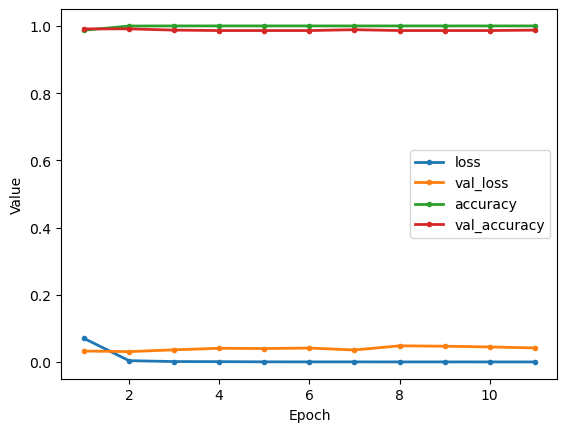

In [24]:
VISU.plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])

In [25]:
VISU.test_report(X_test, y_test, model=model,  args=[model.name, test_scores[1]*100, gene_familly, features_k4, len(dataset)]) 
report.add_report(X_test, y_test, model=model, history=history, args=[model.name, "---"])

 1/32 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step

 7/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step

13/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step

18/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step

24/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step

30/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


 1/32 ━━━━━━━━━━━━━━━━━━━━ 2s 65ms/step

 7/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step

13/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step

19/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step

25/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step

31/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


In [26]:
report.save()

Report saved as Output/Reports/LBD/report_8CNVDI9Q.html


<h4 style="background-color: #80c4e6; display: flex;">
    <ul><li>k=5</li></ul>
</h4>

In [27]:
"""k = 5
X, y, features_k5 = DNA.build_kmer_representation_v2(dataset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_test.head()"""

"k = 5\nX, y, features_k5 = DNA.build_kmer_representation_v2(dataset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False)\nX_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)\nX_test.head()"

In [28]:
"""NUM_CLASS  = 1
SEQ_LENGTH = X_train.shape[1]"""

'NUM_CLASS  = 1\nSEQ_LENGTH = X_train.shape[1]'

* <span style="color: blue; font-weight: bold;">MODEL 3 : FEED-FORWARD NETWORKS</span>

In [29]:
"""name="FEEDFORWARD_k5"
def feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):
    model = Sequential(name=name)
    model.add(Input(shape=(SEQ_LENGTH,)))
    model.add(Dense(2*256, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(num_output, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

# Build & train the model
model = feedforward_net1()
stop_callback = early_stopping(patience=10)
save_callback = model_checkpoint(name)

X_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)
history = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])

# Evaluate and score
test_scores = model.evaluate(X_test, y_test, verbose=0)
train_score = history.history.get('accuracy')[-1]
print("\n[Train Accuracy: {:.2f}% - Test Accuracy: {:.2f}%]".format(train_score*100, test_scores[1]*100))"""

'name="FEEDFORWARD_k5"\ndef feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):\n    model = Sequential(name=name)\n    model.add(Input(shape=(SEQ_LENGTH,)))\n    model.add(Dense(2*256, activation=\'relu\'))\n    model.add(Dropout(rate=0.2))\n    model.add(Dense(128, activation=\'relu\'))\n    model.add(Dropout(rate=0.2))\n    model.add(Dense(64, activation=\'relu\'))\n    model.add(Dropout(rate=0.2))\n    model.add(Dense(num_output, activation=\'sigmoid\'))\n    model.compile(loss=\'binary_crossentropy\', optimizer=\'adam\', metrics=[\'accuracy\'])\n    model.summary()\n    return model\n\n# Build & train the model\nmodel = feedforward_net1()\nstop_callback = early_stopping(patience=10)\nsave_callback = model_checkpoint(name)\n\nX_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)\nhistory = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])\n\n# Evaluate and sc

In [30]:
"""VISU.plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])"""

"VISU.plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])"

In [31]:
"""VISU.test_report(X_test, y_test, model=model,  args=[model.name, test_scores[1]*100, gene_familly, features_k5, len(dataset)]) 
report.add_report(X_test, y_test, model=model, history=history, args=[model.name, "---"])
report.save('end')"""

'VISU.test_report(X_test, y_test, model=model,  args=[model.name, test_scores[1]*100, gene_familly, features_k5, len(dataset)]) \nreport.add_report(X_test, y_test, model=model, history=history, args=[model.name, "---"])\nreport.save(\'end\')'

In [32]:
# END

In [33]:
######################################### DEBUG TO OPTIMIZE K-MER LOEADER FUNCTION ###########################################